## Homework #5. Behaviour exploration improvement
#### Author: `Roman Malynovskyi`
#### Total spent time: `600 minutes`


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from pytz import timezone
from matplotlib.dates import DateFormatter, MonthLocator
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
import nltk
import re
import seaborn as sns
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import ast
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import networkx as nx
from prophet import Prophet
from fuzzywuzzy import fuzz
import numpy as np
import os
import subprocess
from IPython.display import Video, display


/Users/romanmalynovsky/.pyenv/versions/3.8.13/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
/Users/romanmalynovsky/.pyenv/versions/3.8.13/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/romanmalynovsky/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/romanmalynovsky/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/romanmalynovsky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
DIALOGS_MERGED_DATA_PATH = "../data/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "../data/merged_data/dialogs_users_all.csv"

In [4]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

In [5]:
id=749006059
full_id=f'PeerUser(user_id={id})'
df_meta.head()

,dialog_id,name,type,users
0,1032732069,StikStok Bot,Private dialog,"{'user_id': 1032732069, 'first_name': 'StikSto..."
1,810142558,Masha,Private dialog,"{'user_id': 810142558, 'first_name': 'Masha', ..."
2,-1001419124412,UPML_HUB,Group,"{'user_id': 749006059, 'first_name': 'Roman', ..."
3,-1001419124412,UPML_HUB,Group,"{'user_id': 1008861710, 'first_name': 'Антон',..."
4,942619663,diana,Private dialog,"{'user_id': 942619663, 'first_name': 'diana', ..."


**Convert date column to datetime format**

In [6]:
df['date'] = pd.to_datetime(df['date']).dt.tz_convert('UTC')

kyiv_tz = timezone('Europe/Kyiv')

df['date_kyiv'] = df['date'].apply(lambda dt: dt.astimezone(kyiv_tz))

In [7]:
df['year'] = df['date_kyiv'].dt.year
df['month'] = df['date_kyiv'].dt.month
df['day'] = df['date_kyiv'].dt.date
df['hour'] = df['date_kyiv'].dt.hour
df['minute'] = df['date_kyiv'].dt.minute
df['decimal_hour'] = df['hour'] + df['minute'] / 60
user_messages = df[df['from_id'].astype(str) == f'PeerUser(user_id={id})']

In [8]:
private_dialogs = set()
groups = set()
channels = set()

for _, row in df_meta.iterrows():
    dialog_id = row['dialog_id']
    dialog_type = row['type']

    # Categorize by type
    if dialog_type == 'Private dialog':
        private_dialogs.add(dialog_id)
    elif dialog_type == 'Group':
        groups.add(dialog_id)

df['is_channel_message'] = df['from_id'].astype(str).str.startswith("PeerChannel")

private_df = df[df['dialog_id'].isin(private_dialogs)]

groups_df = df[(df['dialog_id'].isin(groups)) & (~df['is_channel_message'])]

channels_df = df[df['is_channel_message']]

groups_df = groups_df[~groups_df['from_id'].astype(str).str.startswith("PeerChannel")]

# Step 4: Print dataset sizes for verification
print(f"Private dialogs: {len(private_df)} messages")
print(f"Groups: {len(groups_df)} messages")
print(f"Channels: {len(channels_df)} messages")

Private dialogs: 184981 messages
Groups: 6639853 messages
Channels: 87411 messages


## Question 1
### When do I wake up and do when I go to sleep?

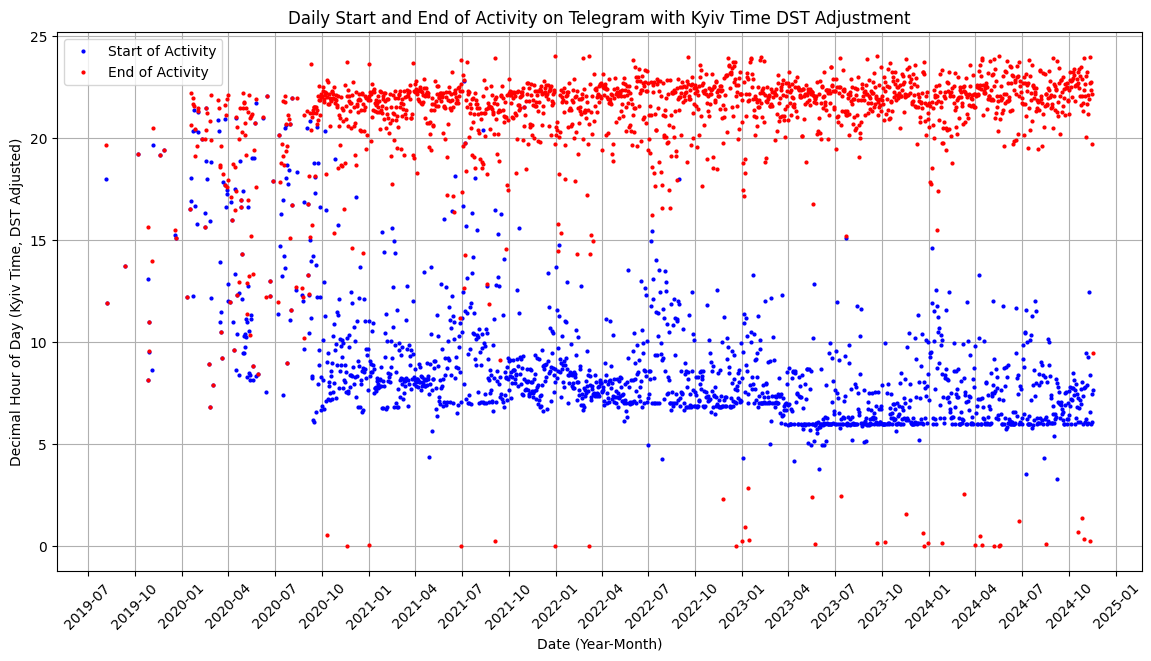

In [9]:
last_activity = user_messages.groupby('day')['decimal_hour'].max().reset_index()
last_activity['activity_type'] = 'End of Day'

first_activity = user_messages.groupby('day')['decimal_hour'].min().reset_index()
first_activity['activity_type'] = 'Start of Day'

for idx, row in first_activity.iterrows():
    if row['decimal_hour'] < 3:
        last_activity = pd.concat([last_activity, pd.DataFrame({
            'day': [row['day'] - timedelta(days=1)],
            'decimal_hour': [row['decimal_hour']],
            'activity_type': ['End of Day']
        })], ignore_index=True)
        first_activity = first_activity.drop(idx)

daily_activity = pd.concat([first_activity, last_activity])

daily_activity['day'] = pd.to_datetime(daily_activity['day'])

plt.figure(figsize=(14, 7))

plt.plot(daily_activity[daily_activity['activity_type'] == 'Start of Day']['day'],
         daily_activity[daily_activity['activity_type'] == 'Start of Day']['decimal_hour'], 
         label='Start of Activity', color='blue', marker='o', linestyle='none', markersize=2)

plt.plot(daily_activity[daily_activity['activity_type'] == 'End of Day']['day'],
         daily_activity[daily_activity['activity_type'] == 'End of Day']['decimal_hour'], 
         label='End of Activity', color='red', marker='o', linestyle='none', markersize=2)

plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.xlabel('Date (Year-Month)')
plt.ylabel('Decimal Hour of Day (Kyiv Time, DST Adjusted)')
plt.title('Daily Start and End of Activity on Telegram with Kyiv Time DST Adjustment')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


#### This plot shows: 
1. I started waking up at 6 am consistelnly in approximetely March 2023
2. Usually I go to bed before 22 pm

In [10]:
daily_start = user_messages.groupby(['year', 'day'])['hour'].min().reset_index(name='start_hour')
daily_end = user_messages.groupby(['year', 'day'])['hour'].max().reset_index(name='end_hour')

daily_activity = pd.merge(daily_start, daily_end, on=['year', 'day'])

yearly_avg_activity = daily_activity.groupby('year').agg({
    'start_hour': 'mean',
    'end_hour': 'mean'
}).reset_index()

print("Average Start and End of Activity by Year:")
print(yearly_avg_activity)

Average Start and End of Activity by Year:
   year  start_hour   end_hour
0  2019   14.000000  14.714286
1  2020   11.822034  18.885593
2  2021    8.668493  20.816438
3  2022    7.884932  21.019178
4  2023    6.602740  21.419178
5  2024    6.803738  21.495327


## Question 2
### What the common bi-grams, sent by me?

In [11]:
stop_words = set(stopwords.words('ukrainian'))
stop_words.update(stopwords.words('english'))

def get_bigrams(text):
    if isinstance(text, str):
        words = [word.lower() for word in re.findall(r'\b[a-zA-Zа-яА-ЯїЇєЄіІґҐ]+\b', text) if word.lower() not in stop_words]
        bigrams = list(ngrams(words, 2))
        return bigrams
    return []

user_messages['bigrams'] = user_messages['message'].apply(get_bigrams)

bigrams_by_year = {}
for year, group in user_messages.groupby('year'):
    bigrams = [bigram for bigrams_list in group['bigrams'] for bigram in bigrams_list]
    bigram_counts = Counter(bigrams)
    bigrams_by_year[year] = bigram_counts.most_common(10) 

bigram_data = []
for year, bigrams in bigrams_by_year.items():
    for bigram, count in bigrams:
        bigram_data.append((year, ' '.join(bigram), count))

bigram_df = pd.DataFrame(bigram_data, columns=['year', 'bigram', 'count'])


/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/4171848627.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['bigrams'] = user_messages['message'].apply(get_bigrams)


/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2133768635.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


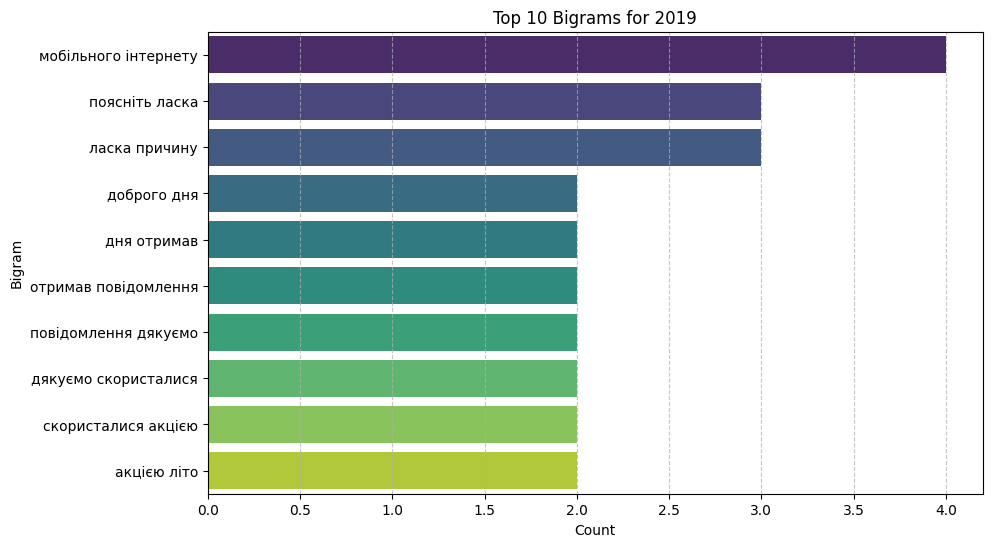

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2133768635.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


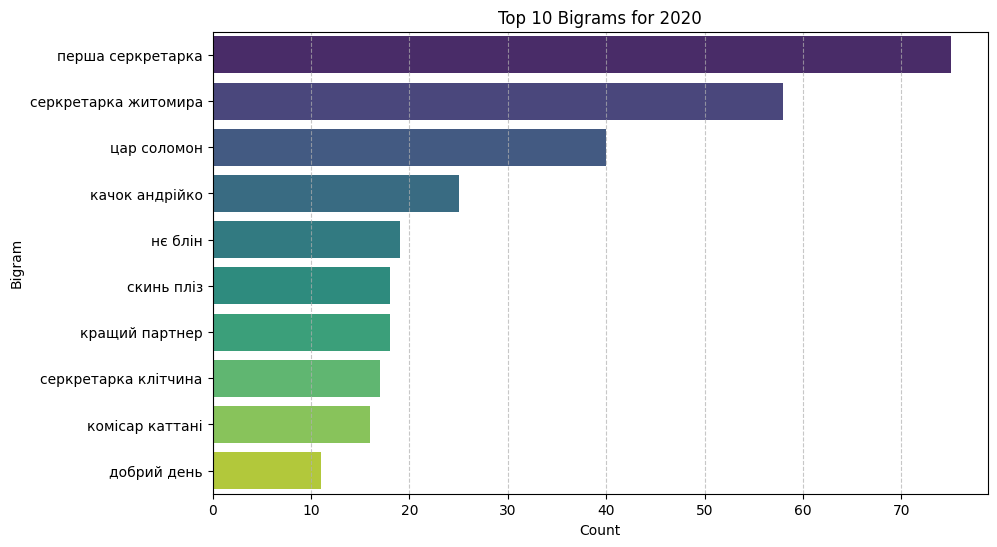

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2133768635.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


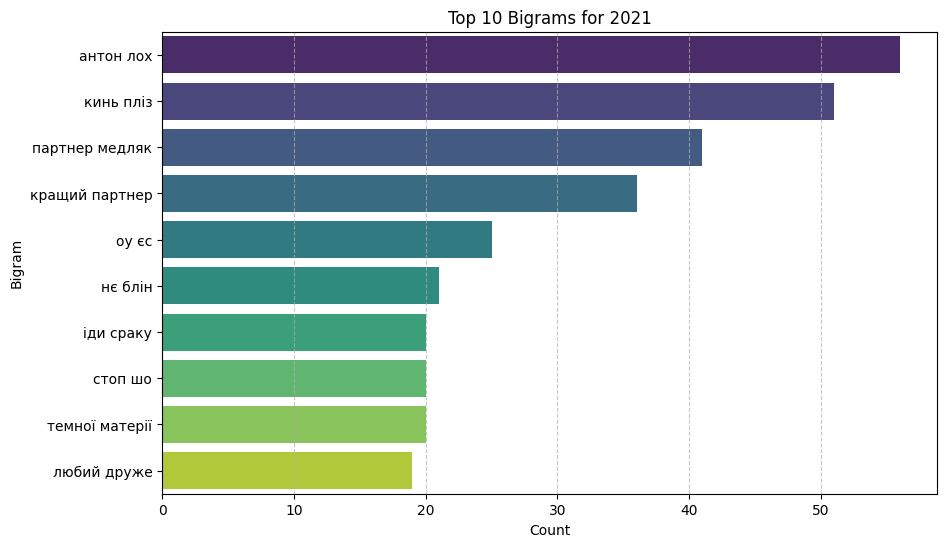

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2133768635.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


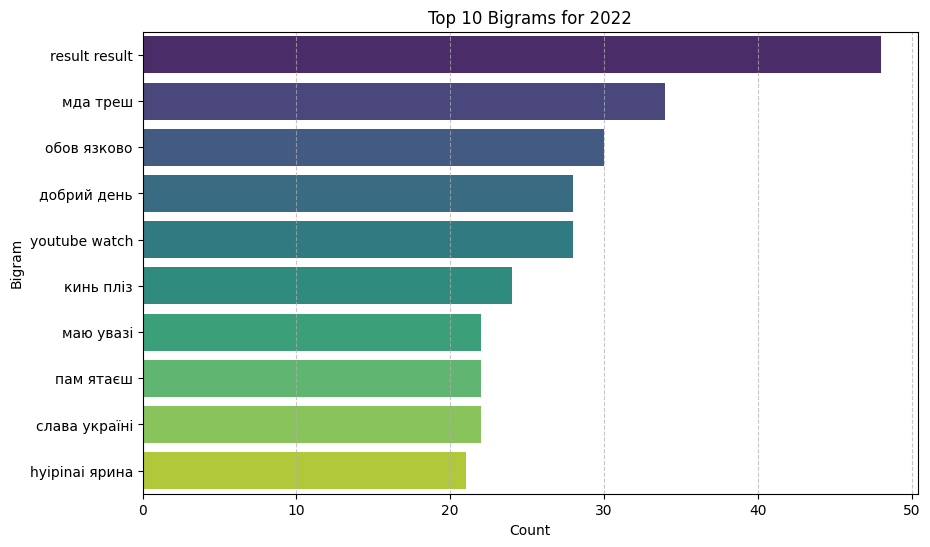

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2133768635.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


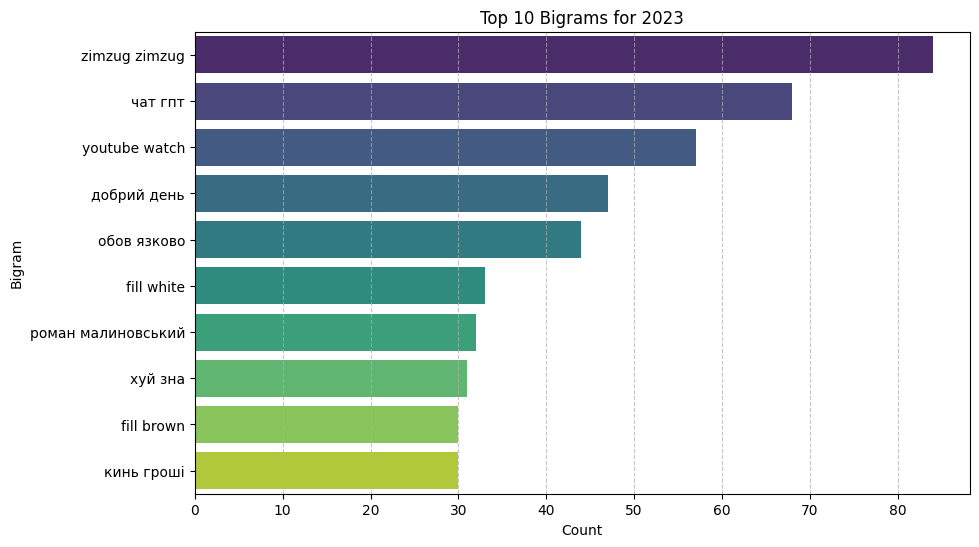

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2133768635.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


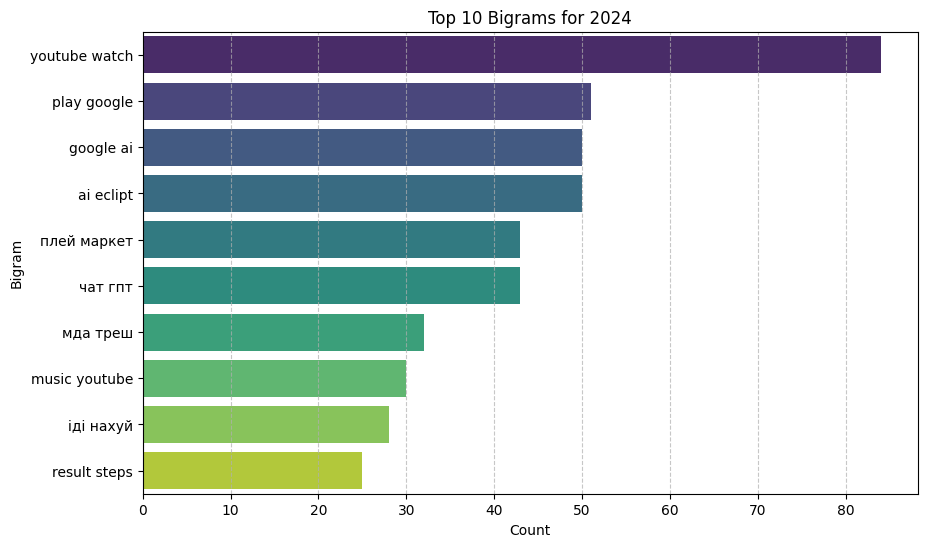

In [12]:
for year in bigram_df['year'].unique():
    year_data = bigram_df[bigram_df['year'] == year]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')
    plt.title(f'Top 10 Bigrams for {year}')
    plt.xlabel('Count')
    plt.ylabel('Bigram')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

## Question 3
### What the common bi-grams, sent by everyone else

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2247859813.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  others_messages['bigrams'] = others_messages['message'].apply(get_bigrams)
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2247859813.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


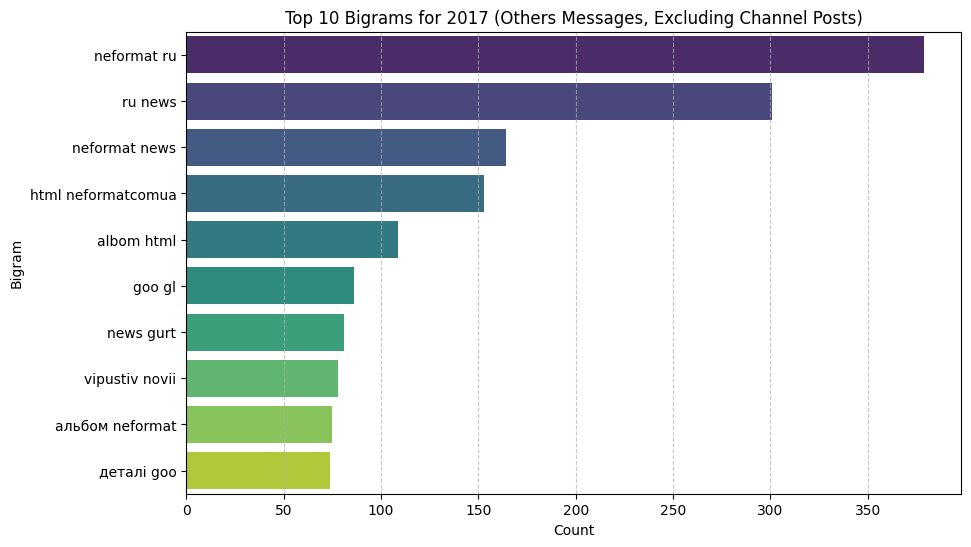

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2247859813.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


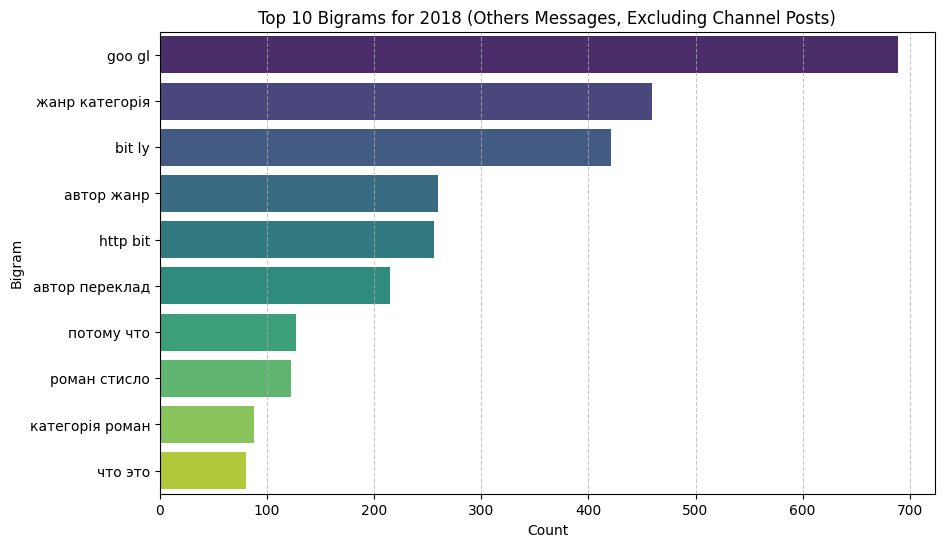

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2247859813.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


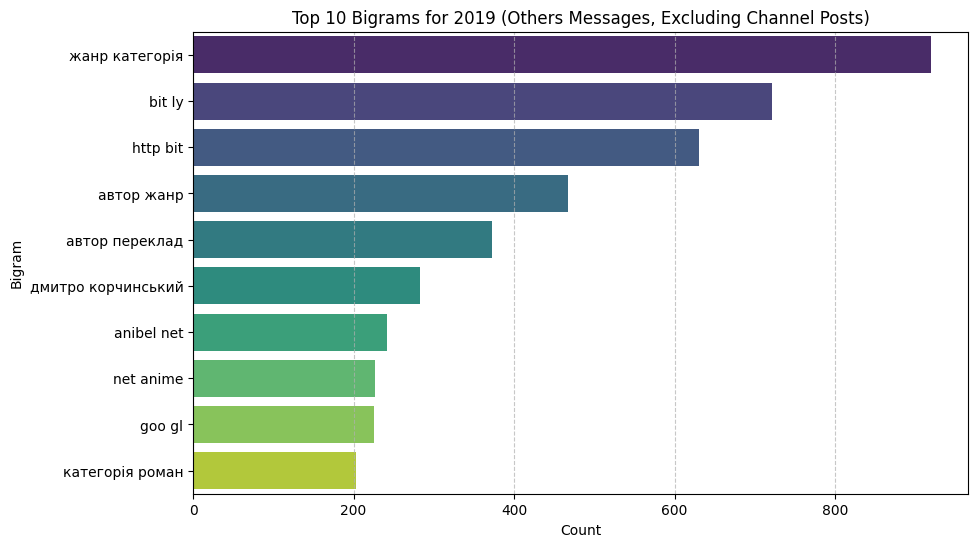

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2247859813.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


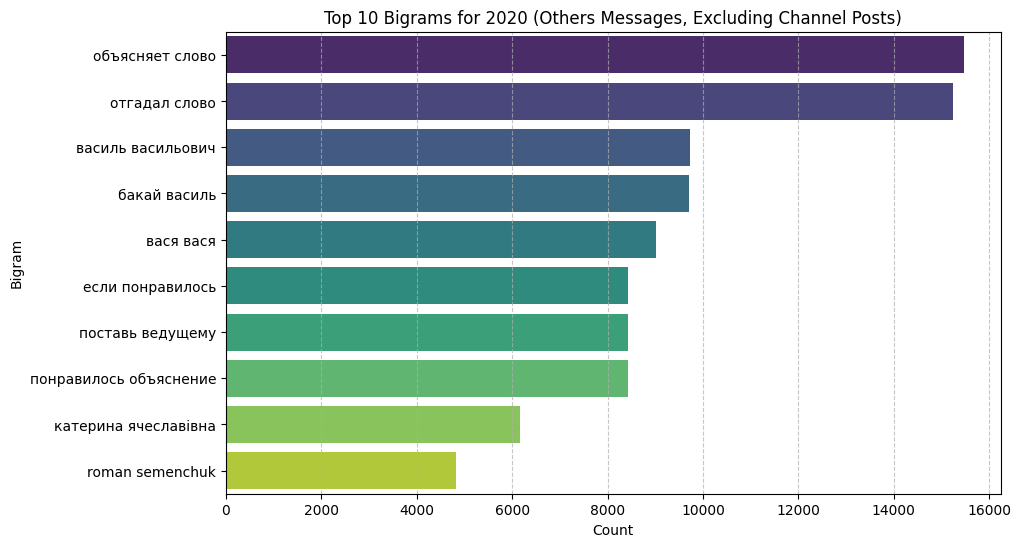

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2247859813.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


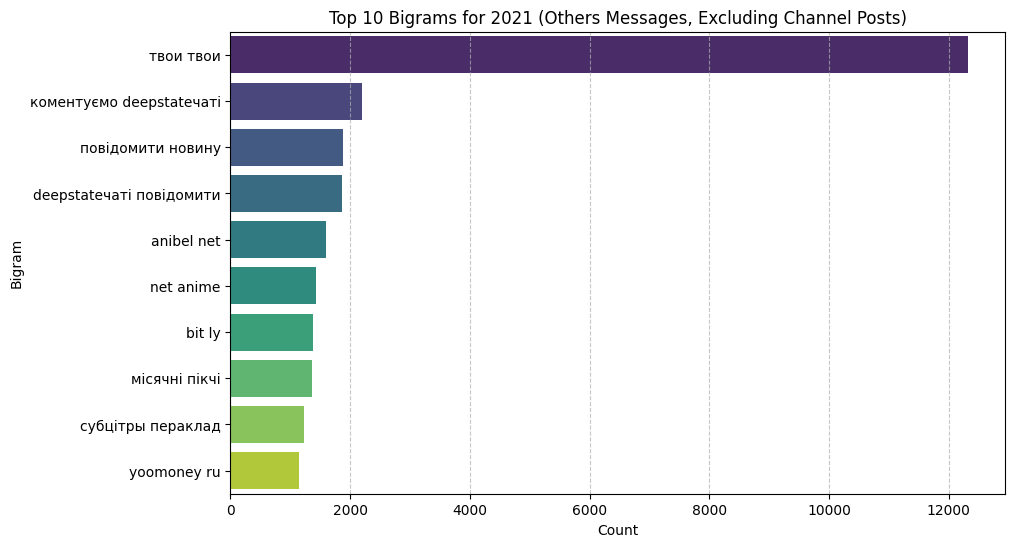

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2247859813.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


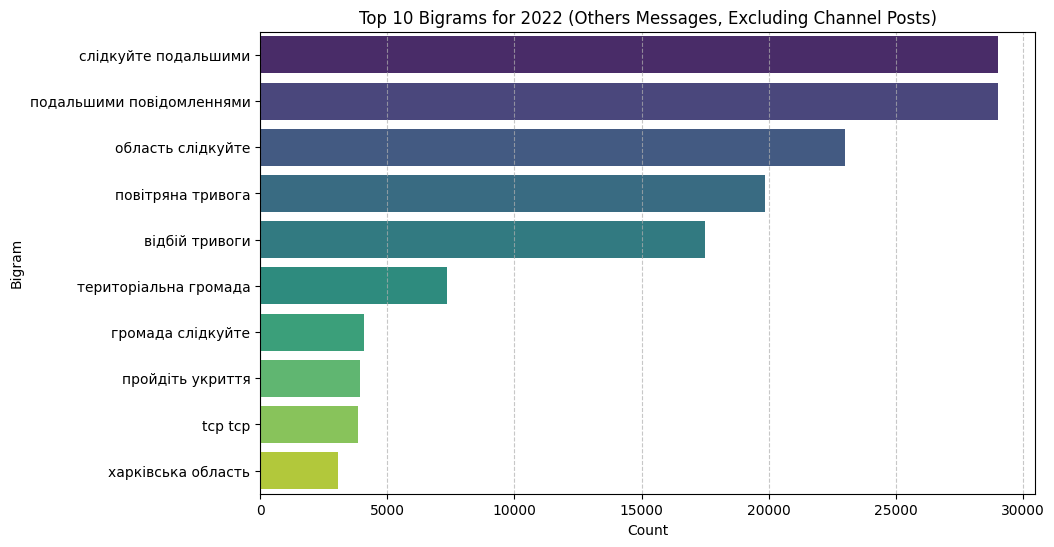

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2247859813.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


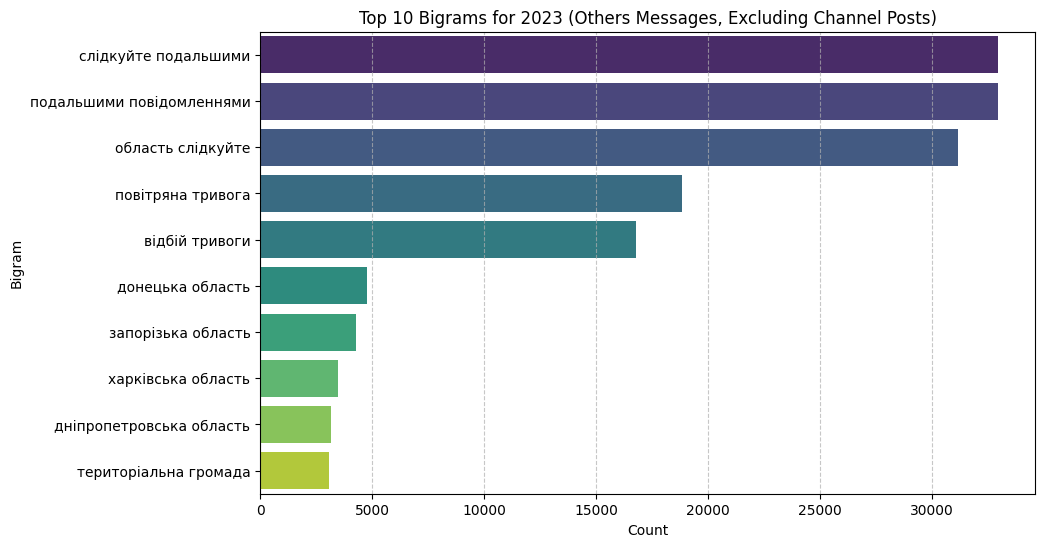

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2247859813.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')


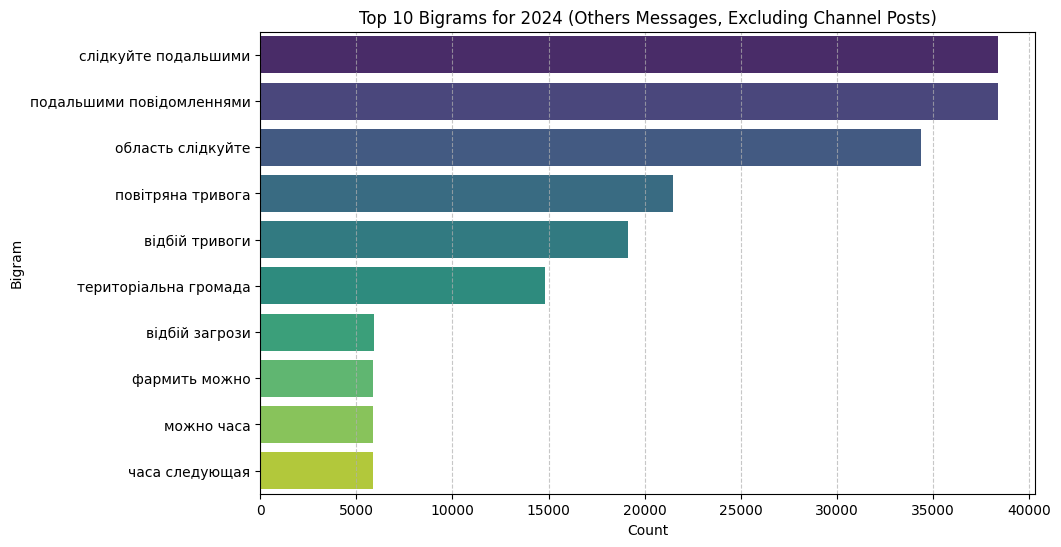

In [13]:
others_messages = df[
    (df['from_id'].astype(str) != full_id) &
    (~df['from_id'].astype(str).str.startswith("PeerChannel")) # without this i get only тривога messages
]

others_messages['bigrams'] = others_messages['message'].apply(get_bigrams)

bigrams_by_year_others = {}
for year, group in others_messages.groupby('year'):
    bigrams = [bigram for bigrams_list in group['bigrams'] for bigram in bigrams_list]
    bigram_counts = Counter(bigrams)
    bigrams_by_year_others[year] = bigram_counts.most_common(10)

bigram_data_others = []
for year, bigrams in bigrams_by_year_others.items():
    for bigram, count in bigrams:
        bigram_data_others.append((year, ' '.join(bigram), count))

bigram_df_others = pd.DataFrame(bigram_data_others, columns=['year', 'bigram', 'count'])

for year in bigram_df_others['year'].unique():
    year_data = bigram_df_others[bigram_df_others['year'] == year]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='bigram', data=year_data, palette='viridis')
    plt.title(f'Top 10 Bigrams for {year} (Others Messages, Excluding Channel Posts)')
    plt.xlabel('Count')
    plt.ylabel('Bigram')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

## Question 4
### What is the ratio of received/sent messages?

Total messages sent: 99891
Total messages received: 85090
Sent/Received Ratio: 0.54 / 0.46


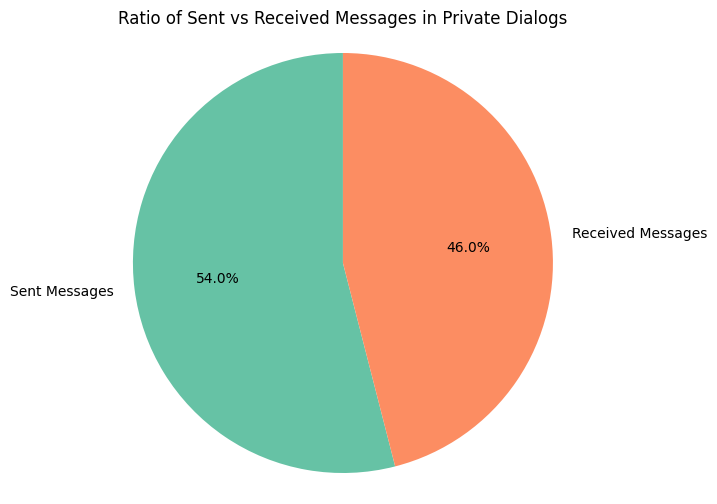

In [14]:
sent_messages = private_df[private_df['from_id'].astype(str) == full_id]
received_messages = private_df[private_df['from_id'].astype(str) != full_id]

sent_count = len(sent_messages)
received_count = len(received_messages)

total_messages = sent_count + received_count
sent_ratio = sent_count / total_messages
received_ratio = received_count / total_messages

print(f"Total messages sent: {sent_count}")
print(f"Total messages received: {received_count}")
print(f"Sent/Received Ratio: {sent_ratio:.2f} / {received_ratio:.2f}")

labels = ['Sent Messages', 'Received Messages']
sizes = [sent_ratio, received_ratio]
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Ratio of Sent vs Received Messages in Private Dialogs')
plt.axis('equal') 
plt.show()


## Question 5: 
### What is the everage voice message length of my voice messages and what is the distribution of lengths / frequency?

In [15]:
voice_messages = df

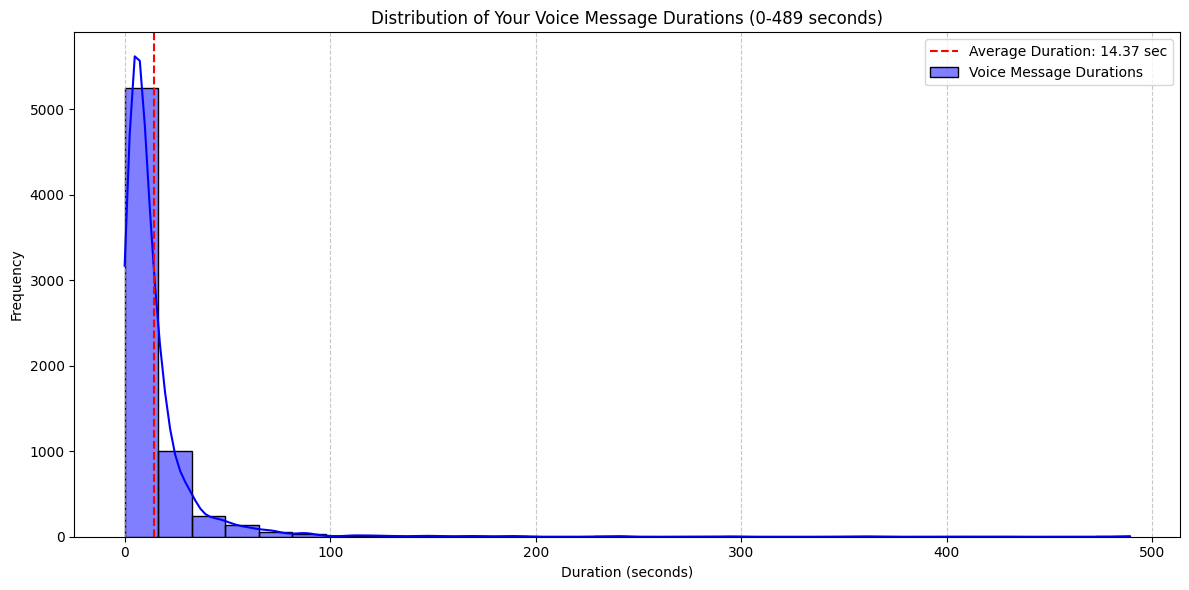

In [16]:
my_voice_messages = voice_messages[voice_messages['from_id'].astype(str) == full_id]
filtered_voice_messages = my_voice_messages[my_voice_messages['duration'] <= 489] # the longest voice message I've sent

avg_duration = filtered_voice_messages['duration'].mean()

plt.figure(figsize=(12, 6))
sns.histplot(filtered_voice_messages['duration'], bins=30, kde=True, color='blue', label='Voice Message Durations')
plt.axvline(avg_duration, color='red', linestyle='--', label=f'Average Duration: {avg_duration:.2f} sec')

# Set labels, title, and grid
plt.title('Distribution of Your Voice Message Durations (0-489 seconds)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

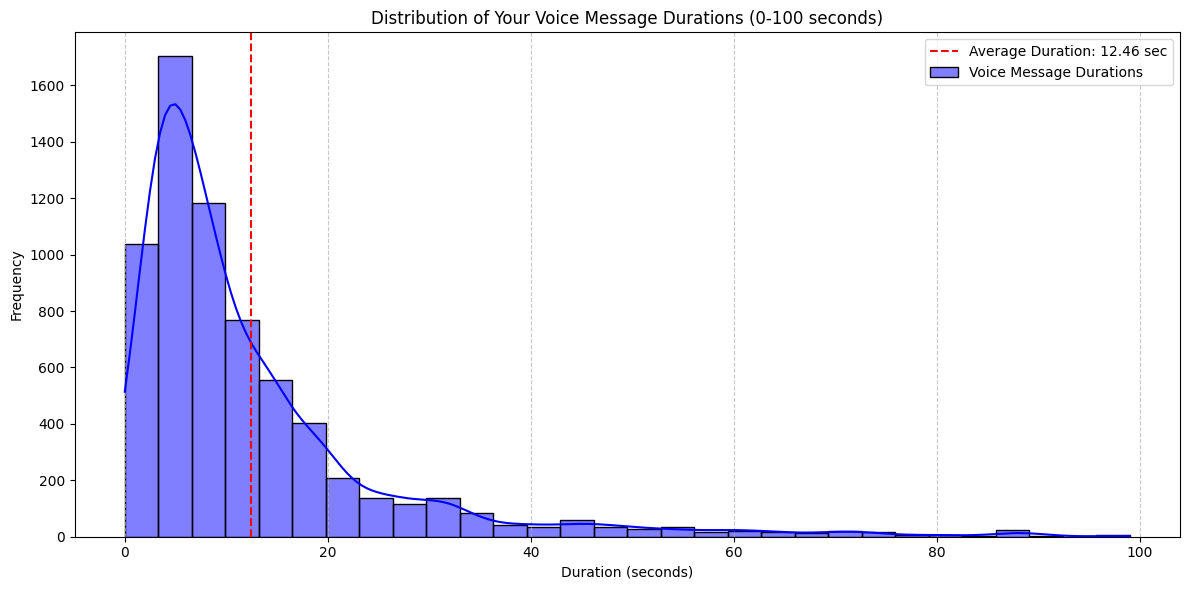

In [17]:
my_voice_messages = voice_messages[voice_messages['from_id'].astype(str) == full_id]
filtered_voice_messages = my_voice_messages[my_voice_messages['duration'] <= 100]

avg_duration = filtered_voice_messages['duration'].mean()

plt.figure(figsize=(12, 6))
sns.histplot(filtered_voice_messages['duration'], bins=30, kde=True, color='blue', label='Voice Message Durations')
plt.axvline(avg_duration, color='red', linestyle='--', label=f'Average Duration: {avg_duration:.2f} sec')

plt.title('Distribution of Your Voice Message Durations (0-100 seconds)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Question 6: 
### What is the everage voice message length of all other messages and what is the idscripubion of lengths / frequency?

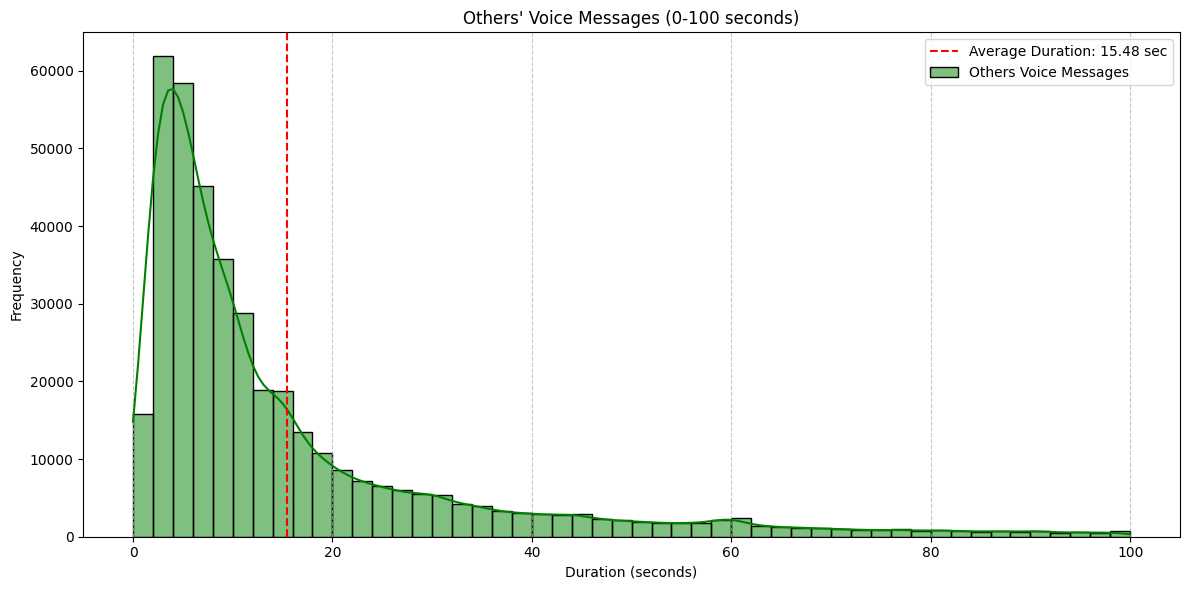

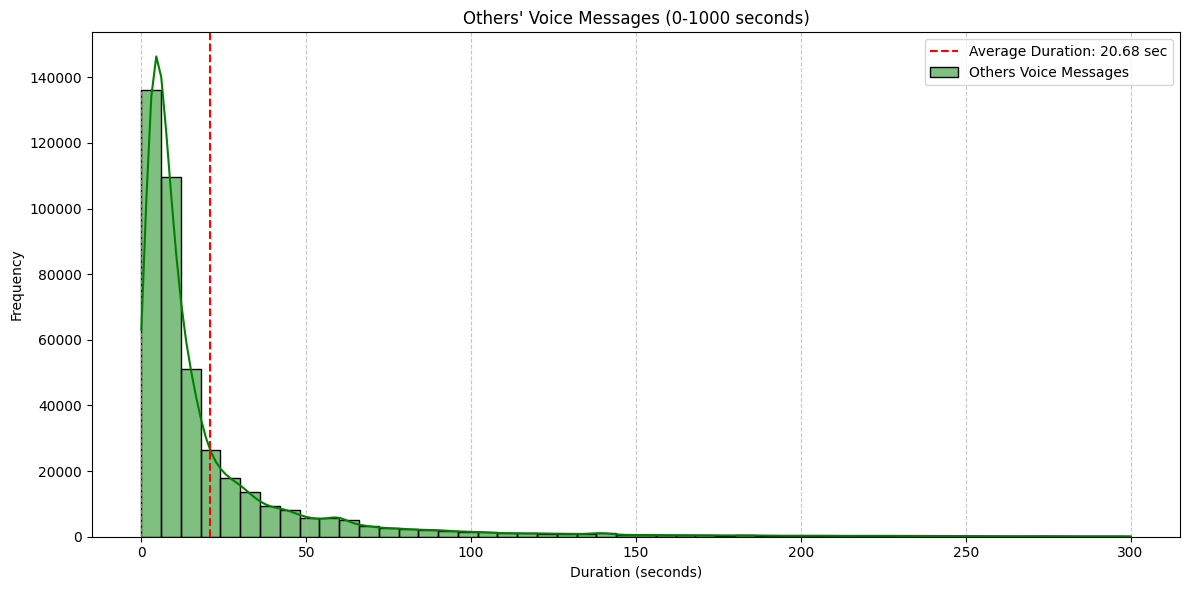

In [18]:
others_voice_messages = voice_messages[voice_messages['from_id'].astype(str) != full_id]

others_voices_100 = others_voice_messages[others_voice_messages['duration'] <= 100]

others_voices_1000 = others_voice_messages[others_voice_messages['duration'] <= 300]

avg_others_100 = others_voices_100['duration'].mean()

avg_others_1000 = others_voices_1000['duration'].mean()

def plot_duration_distribution(data, avg_duration, title, color, label):
    plt.figure(figsize=(12, 6))
    sns.histplot(data['duration'], bins=50, kde=True, color=color, label=label)
    plt.axvline(avg_duration, color='red', linestyle='--', label=f'Average Duration: {avg_duration:.2f} sec')
    plt.title(title)
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_duration_distribution(others_voices_100, avg_others_100, 'Others\' Voice Messages (0-100 seconds)', 'green', 'Others Voice Messages')
plot_duration_distribution(others_voices_1000, avg_others_1000, 'Others\' Voice Messages (0-1000 seconds)', 'green', 'Others Voice Messages')

## Question 7: 
### What is my average activity in telegram in terms of time, months, day of week?

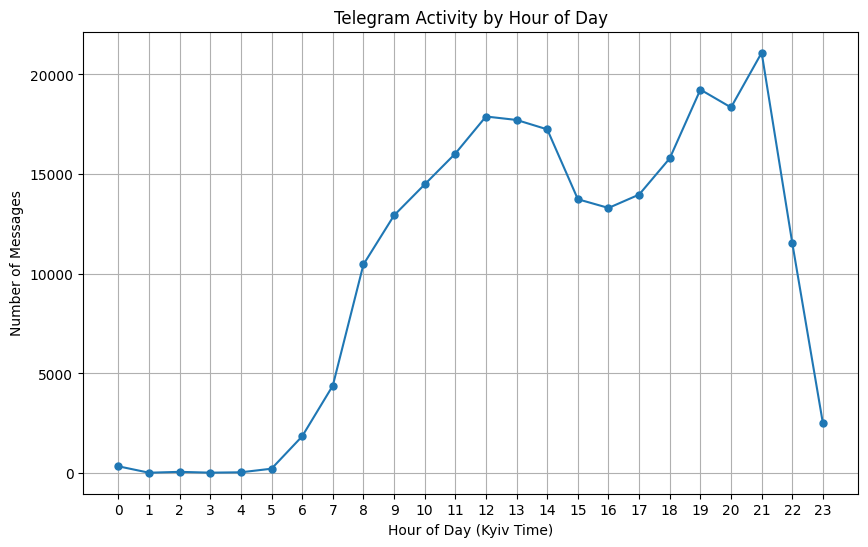

In [19]:
activity_by_hour = user_messages['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(activity_by_hour.index, activity_by_hour.values, marker='o', linestyle='-', markersize=5)
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (Kyiv Time)')
plt.ylabel('Number of Messages')
plt.title('Telegram Activity by Hour of Day')
plt.grid(True)
plt.show()


/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/3457469031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['date_only'] = user_messages['date_kyiv'].dt.date


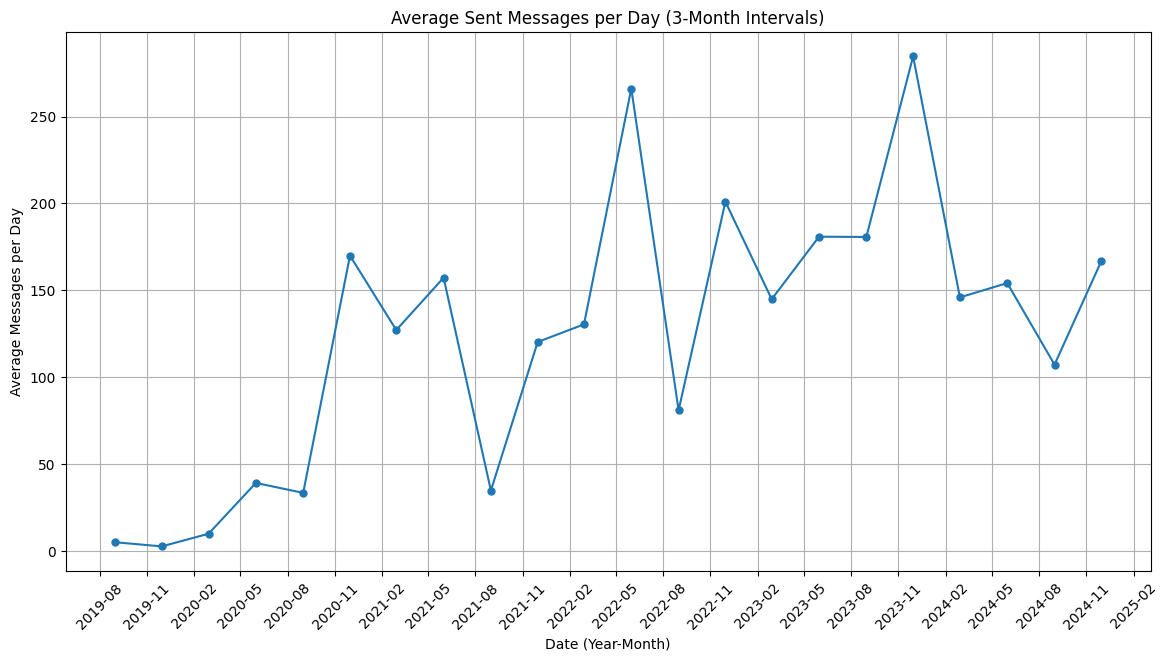

In [20]:
user_messages['date_only'] = user_messages['date_kyiv'].dt.date

messages_per_day = user_messages.groupby('date_only').size()

messages_per_day = messages_per_day.to_frame(name='message_count')
messages_per_day.index = pd.to_datetime(messages_per_day.index)

quarterly_avg_messages = messages_per_day.resample('3M').mean()

plt.figure(figsize=(14, 7))

plt.plot(quarterly_avg_messages.index, quarterly_avg_messages['message_count'], marker='o', linestyle='-', markersize=5)
plt.gca().xaxis.set_major_locator(MonthLocator(interval=3))  
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m')) 

plt.xlabel('Date (Year-Month)')
plt.ylabel('Average Messages per Day')
plt.title('Average Sent Messages per Day (3-Month Intervals)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1769331100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['day_of_week'] = user_messages['date_kyiv'].dt.dayofweek


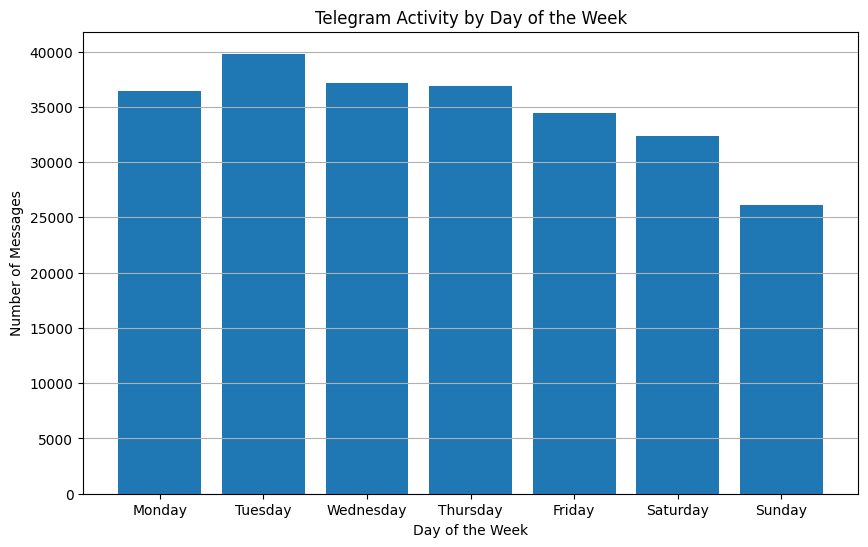

In [21]:
user_messages['day_of_week'] = user_messages['date_kyiv'].dt.dayofweek

activity_by_day = user_messages['day_of_week'].value_counts().sort_index()

day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
plt.bar(day_labels, activity_by_day.values)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Messages')
plt.title('Telegram Activity by Day of the Week')
plt.grid(axis='y')
plt.show()

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1782365116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['month'] = user_messages['date_kyiv'].dt.month
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1782365116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['day_of_week'] = user_messages['date_kyiv'].dt.dayofweek


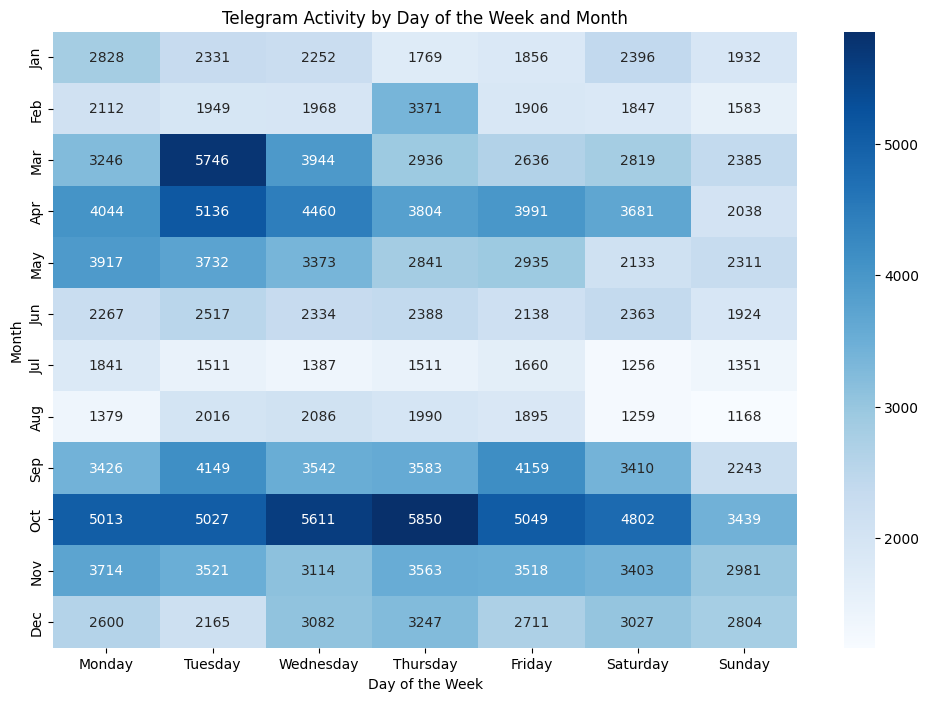

In [22]:
user_messages['month'] = user_messages['date_kyiv'].dt.month
user_messages['day_of_week'] = user_messages['date_kyiv'].dt.dayofweek

# Group messages by month and day of the week
activity_by_month_day = user_messages.groupby(['month', 'day_of_week']).size().unstack(fill_value=0)

# Define labels for the days of the week and months
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(activity_by_month_day, cmap='Blues', annot=True, fmt='d', xticklabels=day_labels, yticklabels=month_labels)
plt.xlabel('Day of the Week')
plt.ylabel('Month')
plt.title('Telegram Activity by Day of the Week and Month')
plt.show()

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1059729809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['month'] = user_messages['date_kyiv'].dt.month


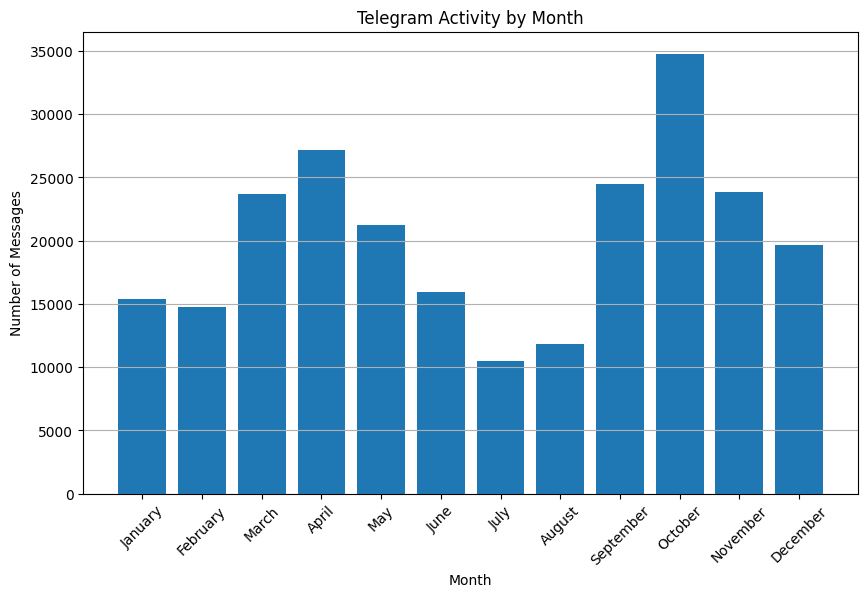

In [23]:
user_messages['month'] = user_messages['date_kyiv'].dt.month

activity_by_month = user_messages['month'].value_counts().sort_index()


month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10, 6))
plt.bar(month_labels, activity_by_month.values)
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.title('Telegram Activity by Month')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Question 8
### What is the distribution of my message types?

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/3897658543.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentage', y='Media Type', data=user_media_df, palette='coolwarm')


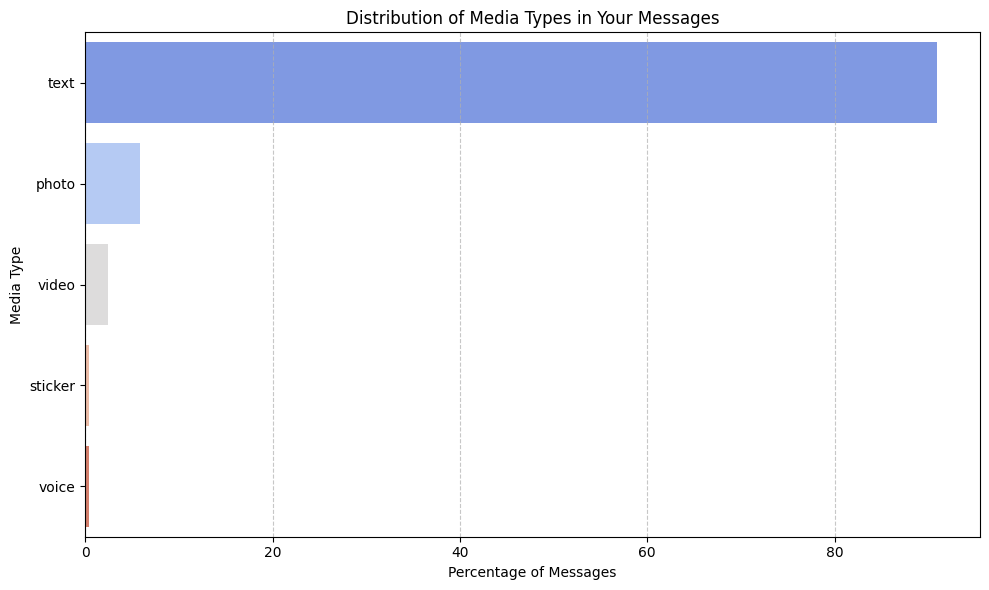

In [24]:
def analyze_user_media_distribution(df):
    media_type_distribution = df['type'].value_counts(normalize=True) * 100 
    return media_type_distribution

user_media_distribution = analyze_user_media_distribution(user_messages)

user_media_df = user_media_distribution.reset_index()
user_media_df.columns = ['Media Type', 'Percentage']

plt.figure(figsize=(10, 6))
sns.barplot(x='Percentage', y='Media Type', data=user_media_df, palette='coolwarm')

plt.title('Distribution of Media Types in Your Messages')
plt.xlabel('Percentage of Messages')
plt.ylabel('Media Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2751929979.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentage', y='Media Type', data=others_media_df, palette='coolwarm')


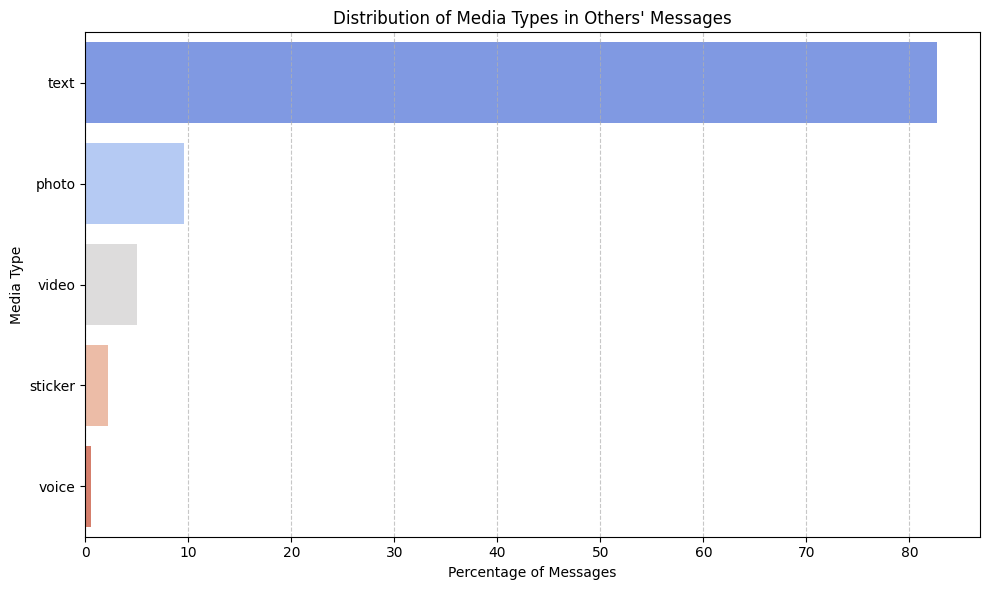

In [25]:
def analyze_media_distribution(df):
    media_type_distribution = df['type'].value_counts(normalize=True) * 100 
    return media_type_distribution

others_messages = df[df['from_id'].astype(str) != full_id]

others_media_distribution = analyze_media_distribution(others_messages)

others_media_df = others_media_distribution.reset_index()
others_media_df.columns = ['Media Type', 'Percentage']

plt.figure(figsize=(10, 6))
sns.barplot(x='Percentage', y='Media Type', data=others_media_df, palette='coolwarm')
plt.title('Distribution of Media Types in Others\' Messages')
plt.xlabel('Percentage of Messages')
plt.ylabel('Media Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Question 10
### What are the most reacted messages, sent by me?

In [26]:
def extract_reactions(reactions):
    try:
        if isinstance(reactions, str):
            reactions_dict = ast.literal_eval(reactions)
            if isinstance(reactions_dict, dict):
                return reactions_dict
        return {}
    except (ValueError, SyntaxError):
        return {}

user_messages['reactions_dict'] = user_messages['reactions'].apply(extract_reactions)
user_messages['reaction_count'] = user_messages['reactions_dict'].apply(len)

top_reacted_messages = user_messages.sort_values(by='reaction_count', ascending=False)

top_reacted_messages = top_reacted_messages[top_reacted_messages['message'].notna() & (top_reacted_messages['message'] != '')].head(10)

for index, row in top_reacted_messages.iterrows():
    print(f"Total Reactions: {row['reaction_count']}")
    print(f"Message: {row['message']}")
    
    reaction_counts = Counter(row['reactions_dict'].values())
    
    print("Reaction Counts:", end=' ')
    for reaction, count in reaction_counts.items():
        print(f"{reaction}: {count}", end=' ')
    print('')


Total Reactions: 39
Message: Який жах
Reaction Counts: 🌚: 23 😁: 16 
Total Reactions: 17
Message: Так, там помилка, студент примат не є нащадком класу люди
Reaction Counts: 👎: 14 🍌: 2 👍: 1 
Total Reactions: 17
Message: "Що робити коли немає світла? Ґвалтувати собак" © Порало
Reaction Counts: 🔥: 3 🤔: 8 🤡: 1 🐳: 1 😈: 1 🌭: 2 😐: 1 
Total Reactions: 16
Message: @Doodlinka від імені усього іпз передаємо тобі догану за відсутність на лекції
Reaction Counts: 😁: 5 👎: 1 ❤: 7 👾: 3 
Total Reactions: 14
Message: рсзо? а може рсзв
Reaction Counts: 👍: 14 
Total Reactions: 13
Message: -
Reaction Counts: 🌭: 4 ❤: 4 😁: 1 ⚡: 2 🍌: 1 🙉: 1 
Total Reactions: 12
Message: яка краля
Reaction Counts: ❤‍🔥: 7 😍: 2 👍: 1 ❤: 1 🤩: 1 
Total Reactions: 11
Message: коли назар відрахувався з другого курсу і перейшов на перший, середній iq обох виріс
Reaction Counts: 🔥: 3 ✍: 3 😁: 5 
Total Reactions: 11
Message: Хтось є в могилянці?
Я мужику вчора позичив на дорогу 38 грн і пообіцяв що буду як боксер стояти наступний день на т

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1002723437.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['reactions_dict'] = user_messages['reactions'].apply(extract_reactions)
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1002723437.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['reaction_count'] = user_messages['reactions_dict'].apply(len)


## Question 11
### What are the most used reactions?
Unfortunately plots does not show them in good format, so i just print top - 20

In [27]:
def extract_reactions(reactions):
    try:
        if isinstance(reactions, str):
            reactions_dict = ast.literal_eval(reactions)
            if isinstance(reactions_dict, dict):
                return reactions_dict
        return {}
    except (ValueError, SyntaxError):
        return {}

df['reactions_dict'] = df['reactions'].apply(extract_reactions)

all_reactions = []
for reactions in df['reactions_dict']:
    all_reactions.extend(reactions.values())

reaction_counts = Counter(all_reactions)

top_20_reactions = reaction_counts.most_common(20)

print("Top 20 Most Used Reactions:")
for reaction, count in top_20_reactions:
    print(f"{reaction}: {count} times")


Top 20 Most Used Reactions:
👍: 3023109 times
😁: 1785644 times
💯: 1038620 times
❤: 886772 times
🤣: 455418 times
🔥: 323558 times
🤡: 179854 times
😢: 152108 times
❤‍🔥: 74768 times
🥰: 72144 times
👏: 67762 times
🤝: 60123 times
🤯: 57510 times
🙏: 55451 times
🤬: 44856 times
🤔: 41200 times
😭: 39636 times
💩: 39332 times
👎: 39259 times
🤮: 38847 times


## Question 12
### What are the most active users in my chats?

In [28]:
user_id_to_name = {}
user_id_to_username = {}
dialog_id_to_name = {}

for _, row in df_meta.iterrows():
    try:
        users_data = ast.literal_eval(row['users']) if isinstance(row['users'], str) else row['users']
        user_id = users_data.get('user_id')
        if user_id:
            name = f"{users_data.get('first_name', '')} {users_data.get('last_name', '')}".strip()
            username = users_data.get('username', '')
            user_id_to_name[user_id] = name if name else f"User {user_id}"
            user_id_to_username[user_id] = username
    except (ValueError, SyntaxError):
        continue

for _, row in df_meta.iterrows():
    dialog_id = row['dialog_id']
    dialog_name = row['name']
    dialog_id_to_name[dialog_id] = dialog_name

filtered_df = df[df['from_id'] != f'PeerUser(user_id={id})']

# Step 3: Extract user IDs from the 'PeerUser(user_id=...)' format
def extract_user_id(peer_user):
    match = re.search(r'PeerUser\(user_id=(\d+)\)', str(peer_user))
    return int(match.group(1)) if match else None

filtered_df['user_id'] = filtered_df['from_id'].apply(extract_user_id)


/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/807491181.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['user_id'] = filtered_df['from_id'].apply(extract_user_id)


/Users/romanmalynovsky/.pyenv/versions/3.8.13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127827 (\N{STRAWBERRY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/romanmalynovsky/.pyenv/versions/3.8.13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/romanmalynovsky/.pyenv/versions/3.8.13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


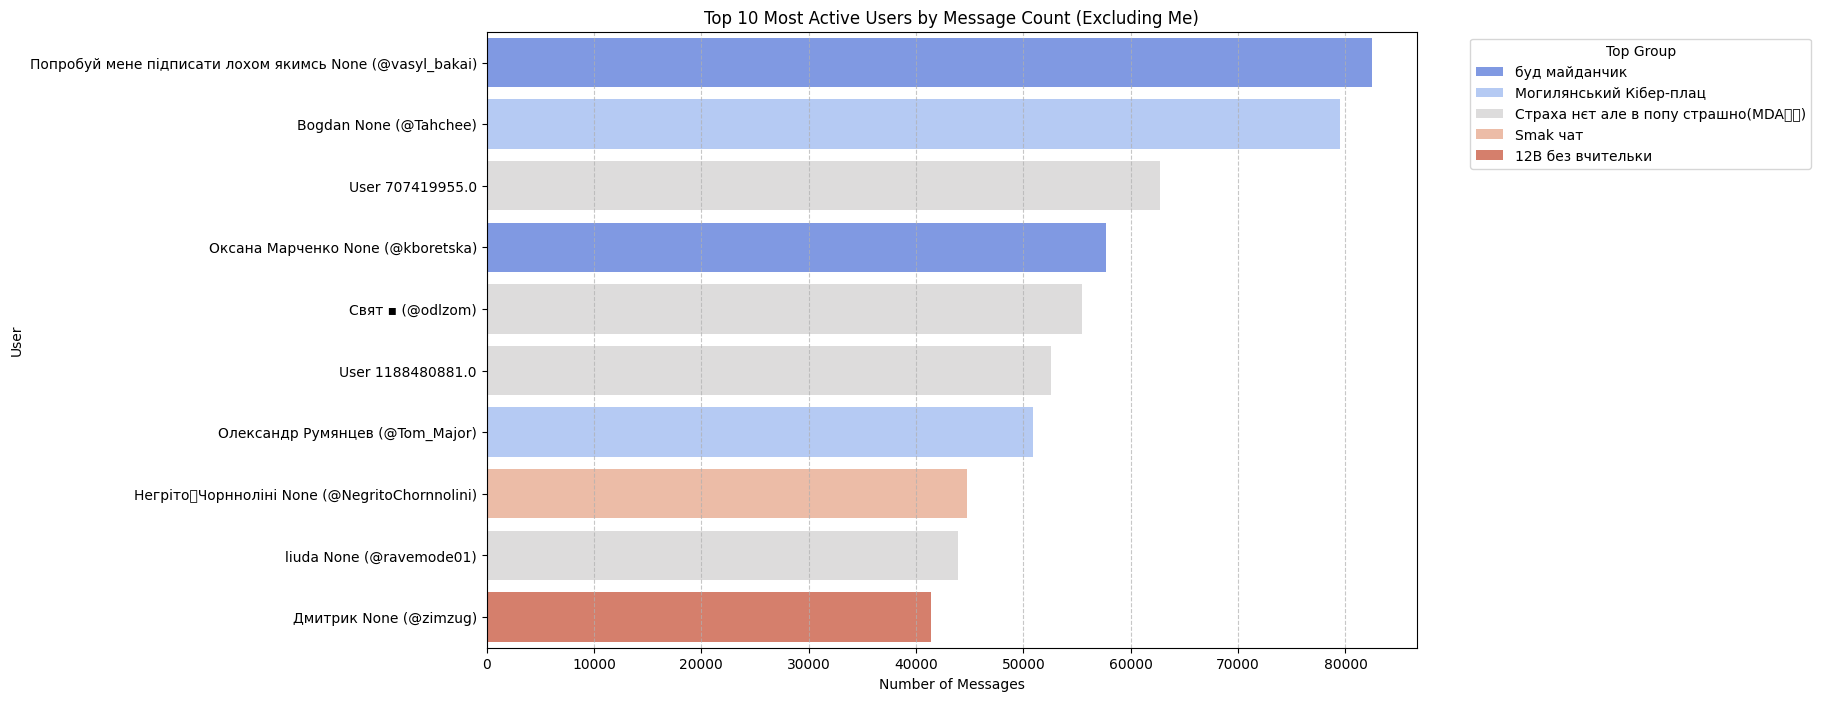

In [29]:
user_group_activity = filtered_df.groupby(['user_id', 'dialog_id']).size().reset_index(name='message_count')
top_group_by_user = user_group_activity.loc[user_group_activity.groupby('user_id')['message_count'].idxmax()]

top_users_by_messages = filtered_df['user_id'].value_counts().head(10)

top_users = []
for user_id, count in top_users_by_messages.items():
    name = user_id_to_name.get(user_id, f"User {user_id}")
    username = user_id_to_username.get(user_id, "")
    
    top_group = top_group_by_user[top_group_by_user['user_id'] == user_id]['dialog_id'].values
    group_id = top_group[0] if len(top_group) > 0 else None
    group_name = dialog_id_to_name.get(group_id, "Unknown Group")
    
    # me
    if username == "Our_Russophobia_is_insufficient":
        continue
    display_name = f"{name} (@{username})" if username else name
    top_users.append((display_name, count, group_name))

top_users_df = pd.DataFrame(top_users, columns=['User', 'Message Count', 'Top Group'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Message Count', y='User', hue='Top Group', data=top_users_df, palette='coolwarm')
plt.title('Top 10 Most Active Users by Message Count (Excluding Me)')
plt.xlabel('Number of Messages')
plt.ylabel('User')
plt.legend(title='Top Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Question 13
### What is the distribution of message length in my chats

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2293275094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['user_id'] = filtered_df['from_id'].apply(extract_user_id)
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2293275094.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['message_length'] = filtered_df['message'].apply(get_message_length)


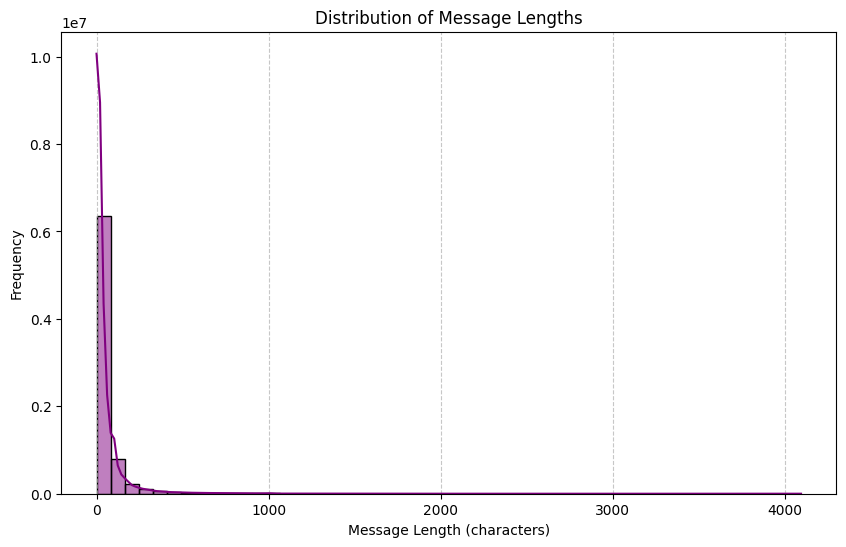

In [30]:
filtered_df['user_id'] = filtered_df['from_id'].apply(extract_user_id)

def get_message_length(msg):
    if isinstance(msg, str):
        return len(msg)
    return 0

filtered_df['message_length'] = filtered_df['message'].apply(get_message_length)

avg_message_length_by_user = filtered_df.groupby('user_id')['message_length'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['message_length'], bins=50, kde=True, color='purple')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


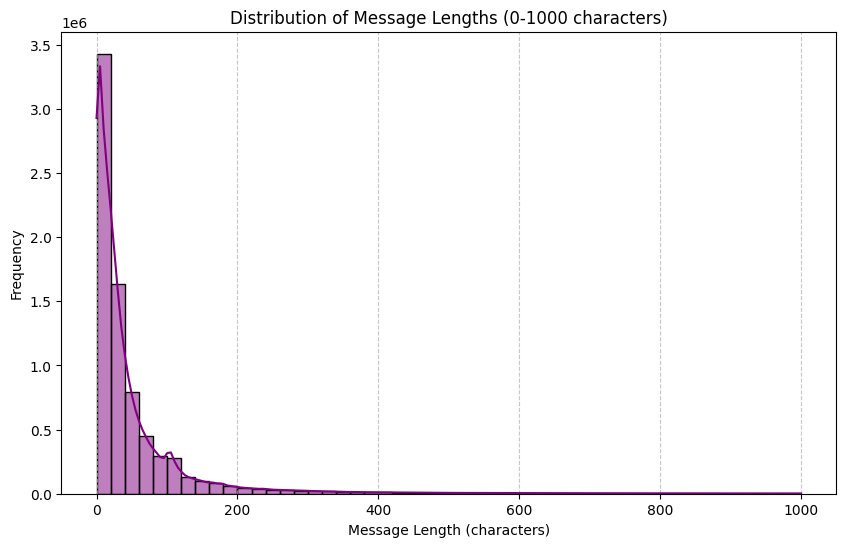

In [31]:

filtered_range_df = filtered_df[(filtered_df['message_length'] >= 0) & (filtered_df['message_length'] <= 1000)]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_range_df['message_length'], bins=50, kde=True, color='purple')
plt.title('Distribution of Message Lengths (0-1000 characters)')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


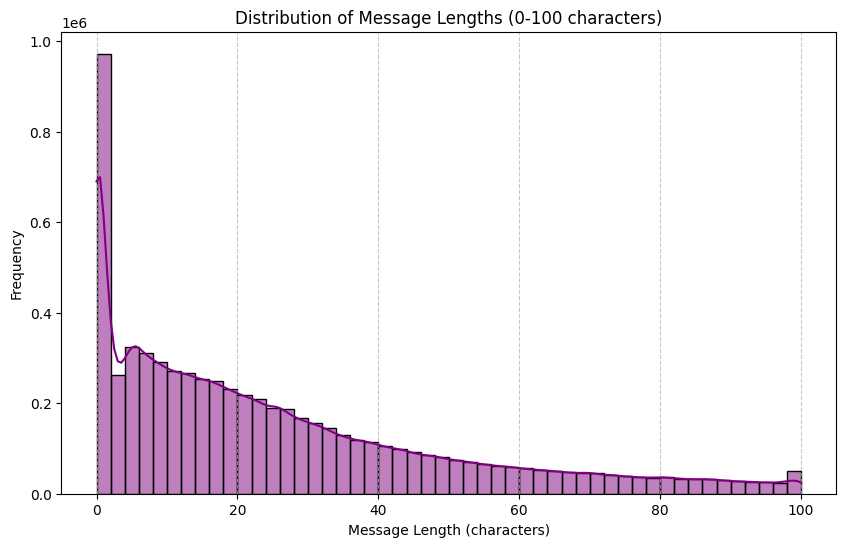

In [32]:

filtered_range_df_100 = filtered_df[(filtered_df['message_length'] >= 0) & (filtered_df['message_length'] <= 100)]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_range_df_100['message_length'], bins=50, kde=True, color='purple')
plt.title('Distribution of Message Lengths (0-100 characters)')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## Question 14
### How posts on channel (f.e on Sternenko channel) engages activity in chat?

In [33]:
STERNENKO_CHAT_ID = "-1001433922609.csv"
STERNENKO_CHAT_ID_PATH = f"../data/dialogs/{STERNENKO_CHAT_ID}"
sterneko_df = pd.read_csv(STERNENKO_CHAT_ID_PATH)
sterneko_df['date'] = pd.to_datetime(df['date']).dt.tz_convert('UTC')
sterneko_df['date_kyiv'] = sterneko_df['date'].apply(lambda dt: dt.astimezone(kyiv_tz))
sterneko_df['year'] = sterneko_df['date_kyiv'].dt.year
sterneko_df['month'] = sterneko_df['date_kyiv'].dt.month
sterneko_df['day'] = sterneko_df['date_kyiv'].dt.date
sterneko_df['hour'] = sterneko_df['date_kyiv'].dt.hour
sterneko_df['minute'] = sterneko_df['date_kyiv'].dt.minute
sterneko_df['decimal_hour'] = sterneko_df['hour'] + sterneko_df['minute'] / 60


In [34]:
sterneko_df['date'] = pd.to_datetime(sterneko_df['date'])

sterneko_df['is_channel_post'] = sterneko_df['from_id'].astype(str).str.startswith("PeerChannel")

channel_posts = sterneko_df[sterneko_df['is_channel_post']]
user_messages = sterneko_df[~sterneko_df['is_channel_post']]

In [35]:
time_window = timedelta(minutes=10)

engagement_data = []

for _, post_row in channel_posts.iterrows():
    post_time = post_row['date']
    
    messages_before = user_messages[
        (user_messages['date'] >= post_time - time_window) &
        (user_messages['date'] < post_time)
    ]
    count_before = len(messages_before)
    
    messages_after = user_messages[
        (user_messages['date'] > post_time) &
        (user_messages['date'] <= post_time + time_window)
    ]
    count_after = len(messages_after)
    
    engagement_data.append({
        'post_time': post_time,
        'messages_before': count_before,
        'messages_after': count_after
    })

engagement_df = pd.DataFrame(engagement_data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


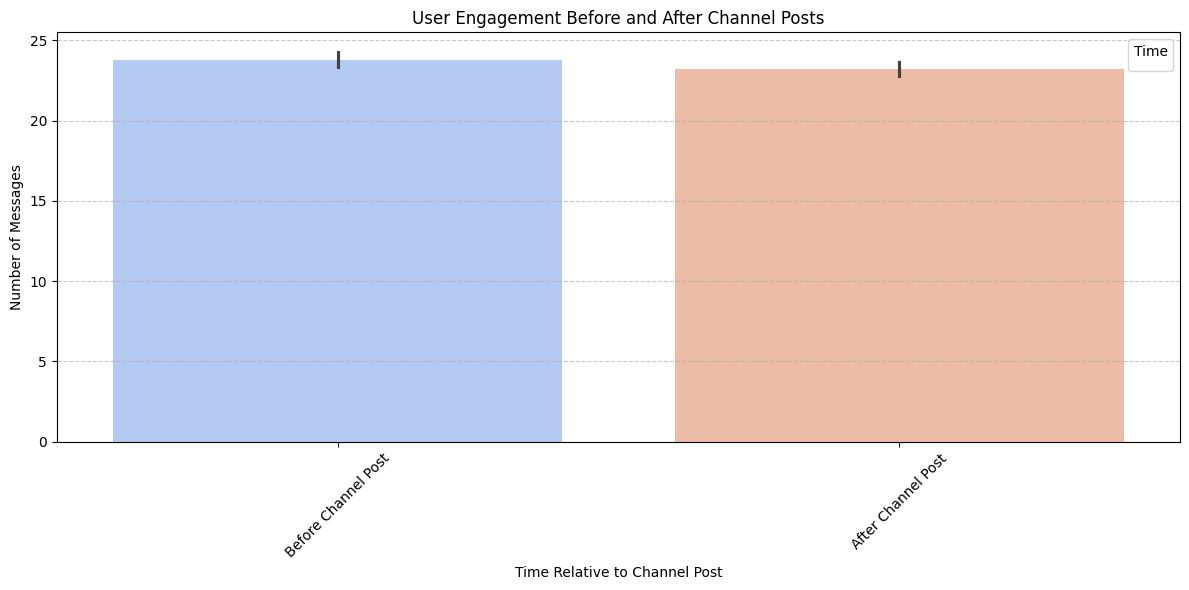

In [36]:
engagement_df_melted = engagement_df.melt(id_vars=['post_time'], 
                                          value_vars=['messages_before', 'messages_after'], 
                                          var_name='Time', value_name='Message Count')

engagement_df_melted['Time'] = engagement_df_melted['Time'].replace({
    'messages_before': 'Before Channel Post',
    'messages_after': 'After Channel Post'
})

plt.figure(figsize=(12, 6))
sns.barplot(data=engagement_df_melted, x='Time', y='Message Count', hue='Time', palette='coolwarm')
plt.title('User Engagement Before and After Channel Posts')
plt.xlabel('Time Relative to Channel Post')
plt.ylabel('Number of Messages')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(title='Time')
plt.tight_layout()
plt.show()

Look like, posts does not engage new activity in the chat

## Question 15
### What is the correlation of dialog type and message length?

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/3147375509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  private_df['message_length'] = private_df['message'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/3147375509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channels_df['message_length'] = channels_df['message'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
/var/folders/pc/vqmykl894s313p24rdg7r01w00

<Figure size 1200x800 with 0 Axes>

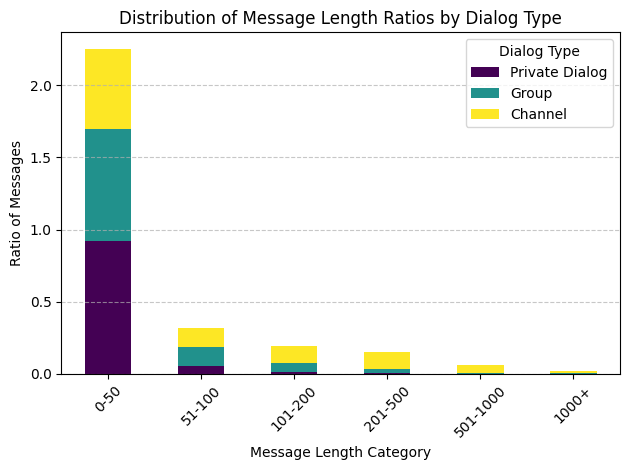

In [37]:
private_df['message_length'] = private_df['message'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
groups_df['message_length'] = groups_df['message'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
channels_df['message_length'] = channels_df['message'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

bins = [0, 50, 100, 200, 500, 1000, np.inf]
labels = ['0-50', '51-100', '101-200', '201-500', '501-1000', '1000+']

private_df['length_category'] = pd.cut(private_df['message_length'], bins=bins, labels=labels, right=False)
groups_df['length_category'] = pd.cut(groups_df['message_length'], bins=bins, labels=labels, right=False)
channels_df['length_category'] = pd.cut(channels_df['message_length'], bins=bins, labels=labels, right=False)

def calculate_length_ratios(df, dialog_type):
    length_ratio = df['length_category'].value_counts(normalize=True).sort_index()
    length_ratio.name = dialog_type
    return length_ratio

private_ratio = calculate_length_ratios(private_df, 'Private Dialog')
groups_ratio = calculate_length_ratios(groups_df, 'Group')
channels_ratio = calculate_length_ratios(channels_df, 'Channel')

length_ratios_df = pd.concat([private_ratio, groups_ratio, channels_ratio], axis=1).fillna(0)

plt.figure(figsize=(12, 8))
length_ratios_df.plot(kind='bar', stacked=True, colormap='viridis')

plt.title('Distribution of Message Length Ratios by Dialog Type')
plt.xlabel('Message Length Category')
plt.ylabel('Ratio of Messages')
plt.legend(title='Dialog Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Looks like, messages with less lengths are more popular for groups and private dialogs, and vice versa, messages with bigges lenths are more popular for channels

## Question 16
### What is the correlation of dialog type and message time send?

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/3652042707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/3652042707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.month
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/3652042707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

<Figure size 1200x600 with 0 Axes>

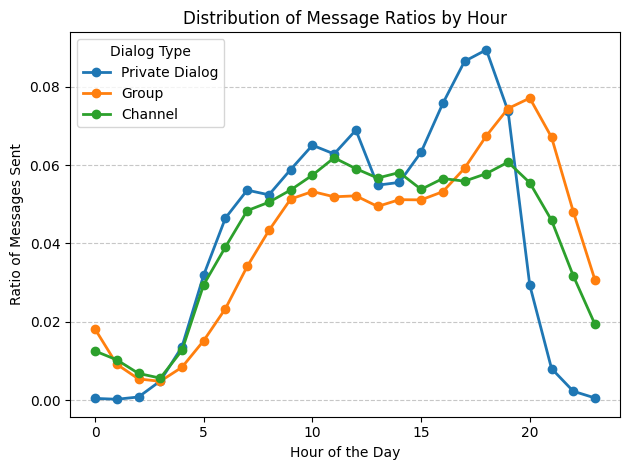

<Figure size 1200x600 with 0 Axes>

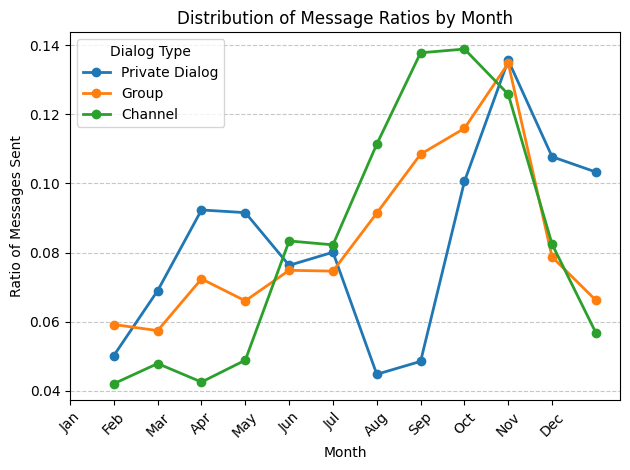

<Figure size 1200x600 with 0 Axes>

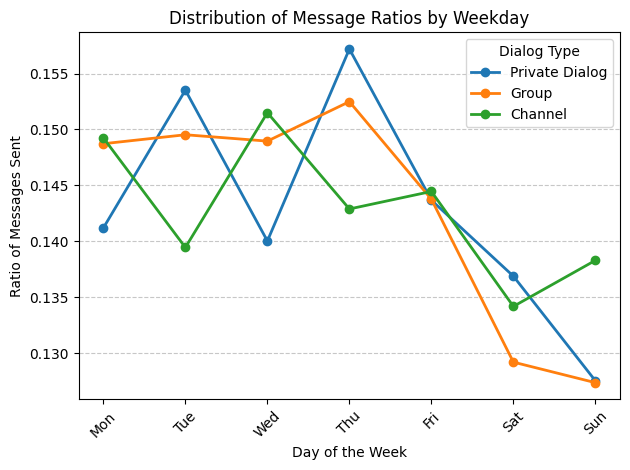

In [38]:
for df in [private_df, groups_df, channels_df]:
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday 

def calculate_ratio(df, column, dialog_type):
    count = df[column].value_counts().sort_index()
    ratio = count / count.sum()
    ratio.name = dialog_type
    return ratio

private_hour_ratio = calculate_ratio(private_df, 'hour', 'Private Dialog')
groups_hour_ratio = calculate_ratio(groups_df, 'hour', 'Group')
channels_hour_ratio = calculate_ratio(channels_df, 'hour', 'Channel')

hourly_ratios_df = pd.concat([private_hour_ratio, groups_hour_ratio, channels_hour_ratio], axis=1).fillna(0)

private_month_ratio = calculate_ratio(private_df, 'month', 'Private Dialog')
groups_month_ratio = calculate_ratio(groups_df, 'month', 'Group')
channels_month_ratio = calculate_ratio(channels_df, 'month', 'Channel')

monthly_ratios_df = pd.concat([private_month_ratio, groups_month_ratio, channels_month_ratio], axis=1).fillna(0)

private_weekday_ratio = calculate_ratio(private_df, 'weekday', 'Private Dialog')
groups_weekday_ratio = calculate_ratio(groups_df, 'weekday', 'Group')
channels_weekday_ratio = calculate_ratio(channels_df, 'weekday', 'Channel')

weekday_ratios_df = pd.concat([private_weekday_ratio, groups_weekday_ratio, channels_weekday_ratio], axis=1).fillna(0)

def plot_ratios(df, title, xlabel, xticks_labels=None):
    plt.figure(figsize=(12, 6))
    df.plot(kind='line', marker='o', linewidth=2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Ratio of Messages Sent')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Dialog Type')
    if xticks_labels:
        plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels, rotation=45)
    plt.tight_layout()
    plt.show()

plot_ratios(hourly_ratios_df, 'Distribution of Message Ratios by Hour', 'Hour of the Day')

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plot_ratios(monthly_ratios_df, 'Distribution of Message Ratios by Month', 'Month', month_labels)

weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot_ratios(weekday_ratios_df, 'Distribution of Message Ratios by Weekday', 'Day of the Week', weekday_labels)

## Question 17
### What is the correlation of message types depending on dialog type?

<Figure size 1200x800 with 0 Axes>

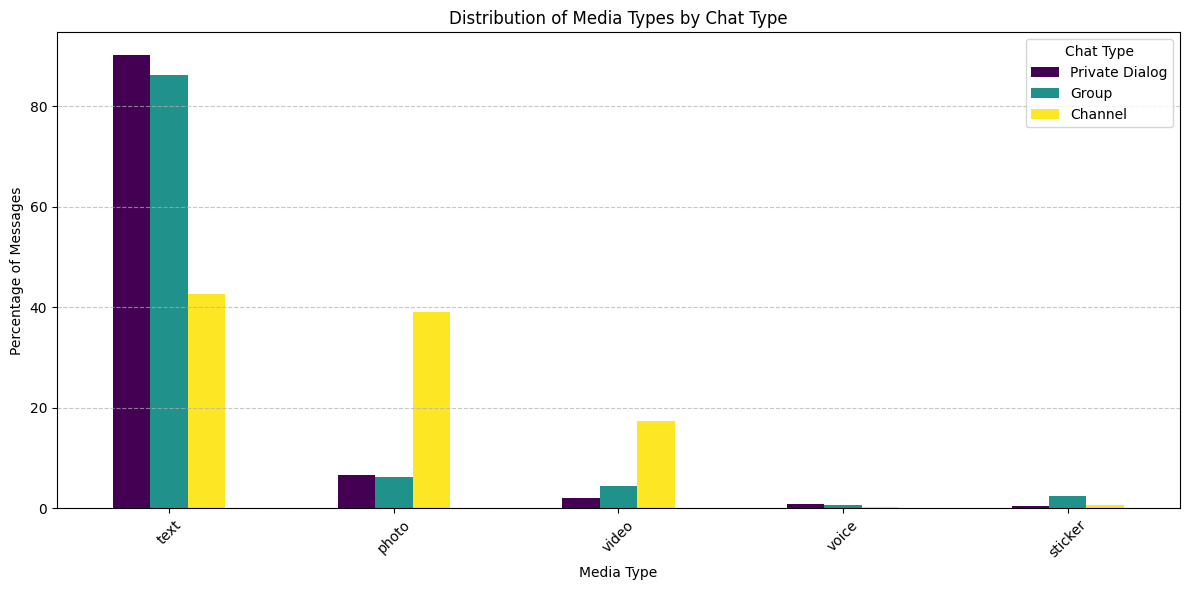

In [39]:
def analyze_media_type_distribution(df, chat_type):
    media_type_distribution = df['type'].value_counts(normalize=True) * 100
    media_type_distribution.name = chat_type
    return media_type_distribution

private_media_distribution = analyze_media_type_distribution(private_df, 'Private Dialog')
groups_media_distribution = analyze_media_type_distribution(groups_df, 'Group')
channels_media_distribution = analyze_media_type_distribution(channels_df, 'Channel')

media_distribution_df = pd.concat([private_media_distribution, groups_media_distribution, channels_media_distribution], axis=1).fillna(0)

plt.figure(figsize=(12, 8))
media_distribution_df.plot(kind='bar', stacked=False, figsize=(12, 6), colormap='viridis')

plt.title('Distribution of Media Types by Chat Type')
plt.xlabel('Media Type')
plt.ylabel('Percentage of Messages')
plt.legend(title='Chat Type')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Looks like, messages with less lengths are more popular for groups and private dialogs, and vice versa, messages with bigges lenths are more popular for channels

Day-time of send looks almost the same, which makes sense, because channel administators try to post something on times when most users are online.


## Question 18
### How can we forecast future chat activity in a channel based on historical data?

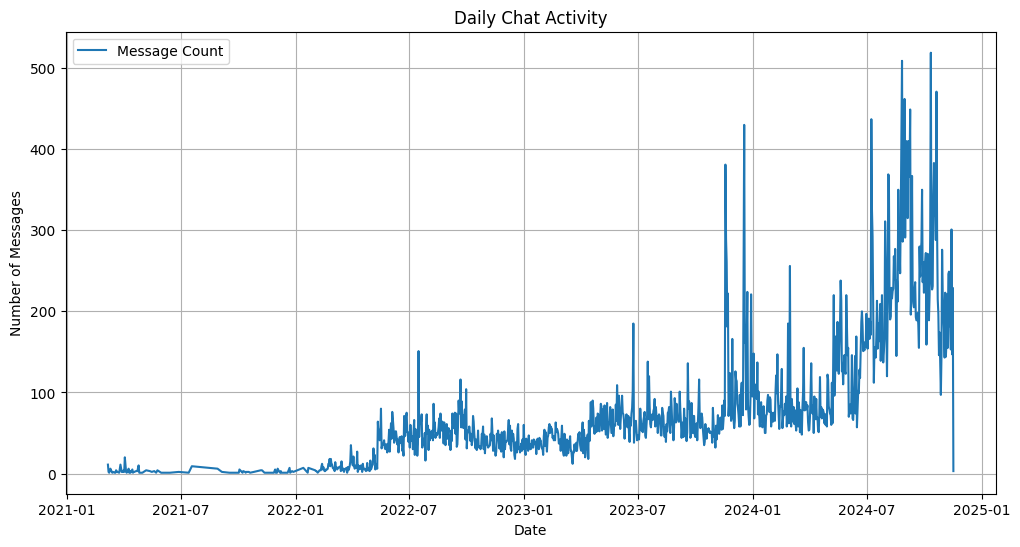

In [40]:
daily_message_count = df.groupby(df['date'].dt.date).size().reset_index(name='message_count')

daily_message_count.columns = ['ds', 'y']

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_message_count, x='ds', y='y', label='Message Count')
plt.title('Daily Chat Activity')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.show()

In [41]:
# Train the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(daily_message_count)


07:31:49 - cmdstanpy - INFO - Chain [1] start processing
07:31:50 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1200x600 with 0 Axes>

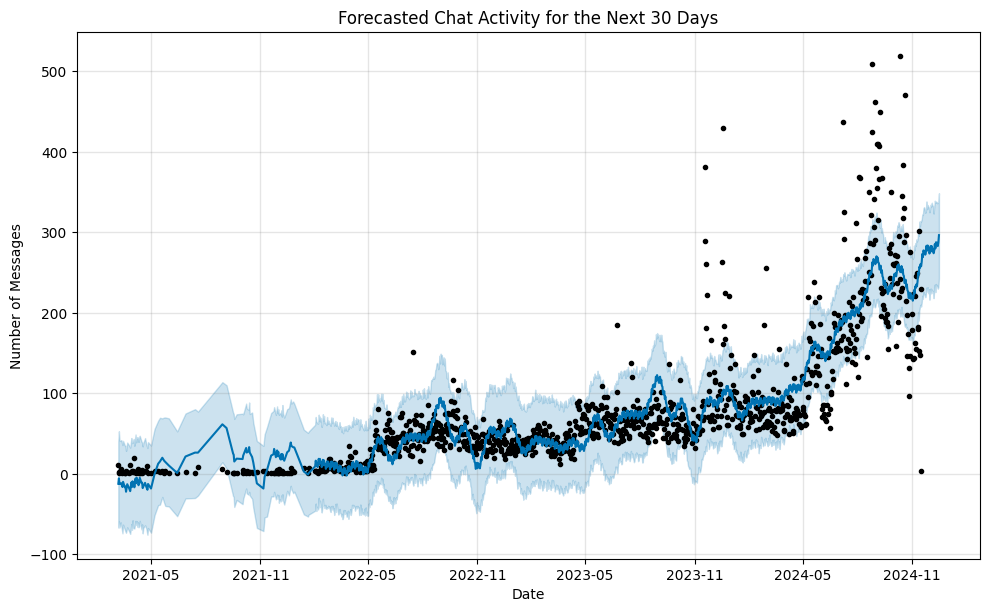

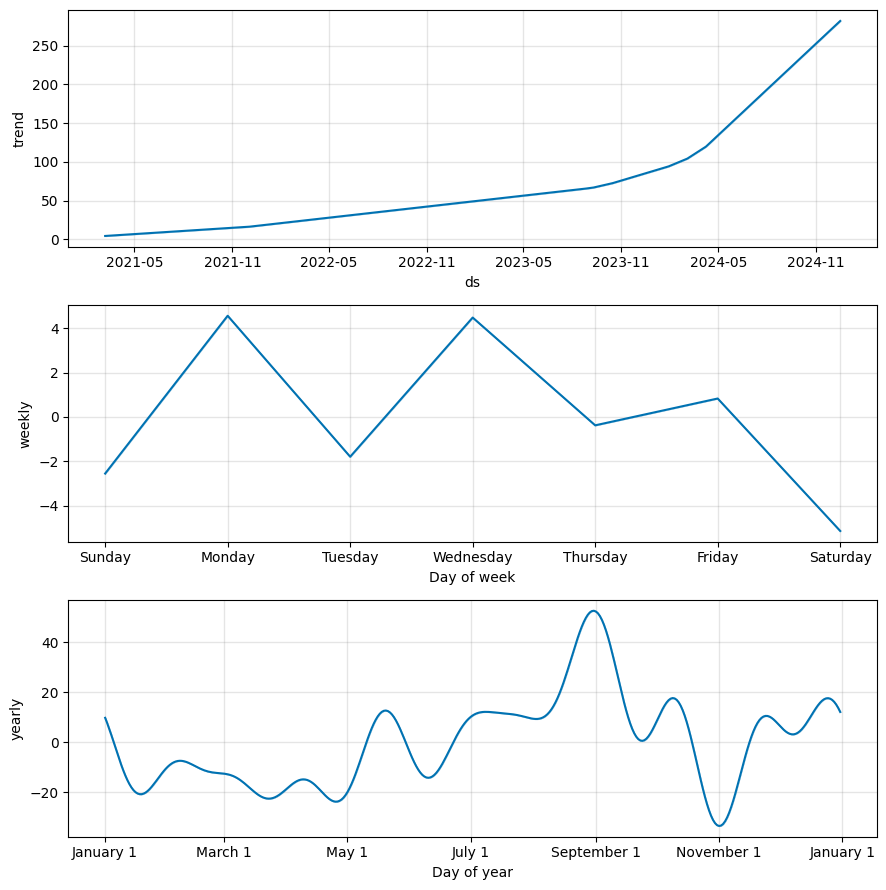

In [42]:
future = model.make_future_dataframe(periods=30)

forecast = model.predict(future)

plt.figure(figsize=(12, 6))
model.plot(forecast)
plt.title('Forecasted Chat Activity for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.show()

model.plot_components(forecast)
plt.show()


## Question 19
### What languages do I speak?

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1192019562.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_messages['language'] = user_messages['message'].dropna().apply(detect_language)
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1192019562.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Language', data=language_stats, palette='viridis')


Top 20 Language Usage Statistics:
   Language   Count  Percentage
0        uk  712223   78.677375
1        ru   80415    8.883231
2        bg   38786    4.284586
3        mk   31162    3.442383
4   unknown   28669    3.166988
5        en    3729    0.411933
6        af    1650    0.182271
7        no    1338    0.147805
8        et    1043    0.115217
9        de     995    0.109915
10       es     884    0.097653
11       sv     368    0.040652
12       fi     299    0.033030
13       pl     250    0.027617
14       ro     246    0.027175
15       sl     231    0.025518
16       it     231    0.025518
17       id     216    0.023861
18       pt     211    0.023309
19       tl     204    0.022535


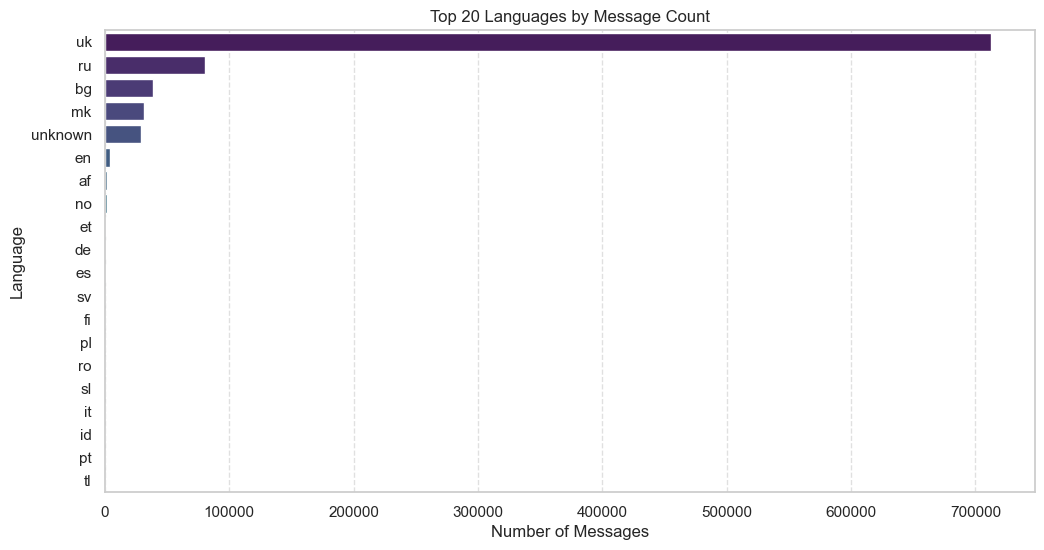

In [43]:
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

user_messages['language'] = user_messages['message'].dropna().apply(detect_language)

language_counts = user_messages['language'].value_counts().head(20)
language_percentages = (language_counts / user_messages['language'].count() * 100)

language_stats = pd.DataFrame({
    'Language': language_counts.index,
    'Count': language_counts.values,
    'Percentage': language_percentages.values
})

print("Top 20 Language Usage Statistics:")
print(language_stats)
sns.set(style='whitegrid')

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Language', data=language_stats, palette='viridis')
plt.title('Top 20 Languages by Message Count')
plt.xlabel('Number of Messages')
plt.ylabel('Language')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()


## Question 20
### What is the most popular GIF sent by me?

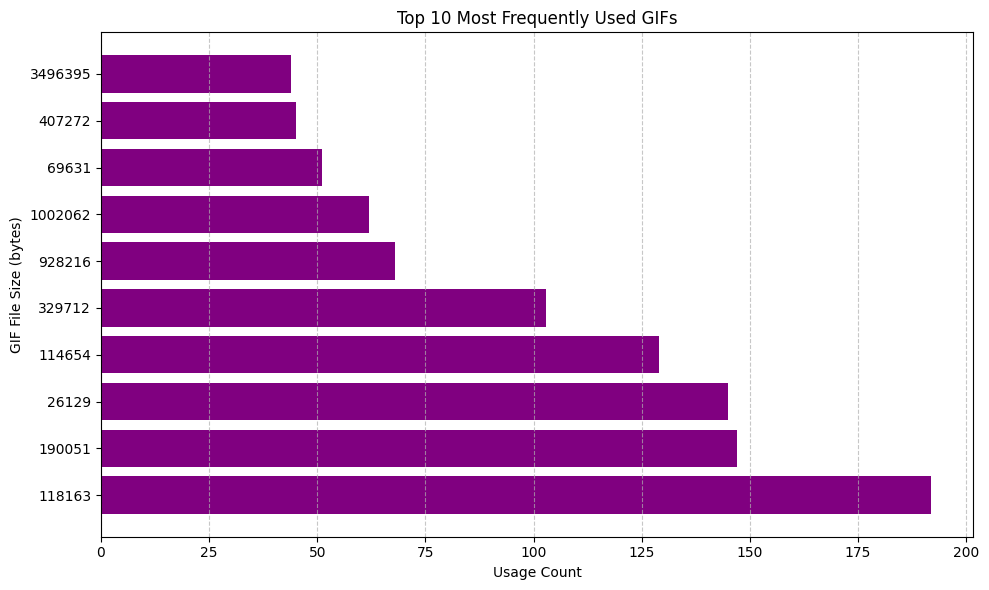

Most Common GIF: 76780.gif | Used 192 times


In [2]:
gifs_folder = "../data/gifs_folder"
mp4_folder = "../data/mp4_folder"
os.makedirs(mp4_folder, exist_ok=True)

gif_files = [f for f in os.listdir(gifs_folder) if f.endswith('.gif')]
gif_sizes = {}

for gif in gif_files:
    file_path = os.path.join(gifs_folder, gif)
    file_size = os.path.getsize(file_path)
    if file_size in gif_sizes:
        gif_sizes[file_size]['count'] += 1
        gif_sizes[file_size]['files'].append(gif)
    else:
        gif_sizes[file_size] = {'count': 1, 'files': [gif]}

gif_df = pd.DataFrame([
    (size, info['count'], info['files'][0]) for size, info in gif_sizes.items()
], columns=['File Size (bytes)', 'Count', 'Example File'])

gif_df = gif_df.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(gif_df['File Size (bytes)'].astype(str), gif_df['Count'], color='purple')
plt.xlabel('Usage Count')
plt.ylabel('GIF File Size (bytes)')
plt.title('Top 10 Most Frequently Used GIFs')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

def convert_gif_to_mp4(gif_path, output_path):
    command = [
        "ffmpeg", "-y",  
        "-i", gif_path,  
        "-vf", "fps=24", 
        "-pix_fmt", "yuv420p", 
        output_path
    ]

    with open(os.devnull, 'w') as fnull:
        subprocess.run(command, stdout=fnull, stderr=fnull, check=True)

def display_video(video_path):
    """
    Displays an MP4 video in a Jupyter Notebook.
    """
    return Video(video_path, embed=True, width=600, height=400)

most_common_gif = gif_df.iloc[0]
gif_file = most_common_gif['Example File']
gif_path = os.path.join(gifs_folder, gif_file)
mp4_path = os.path.join(mp4_folder, gif_file.replace('.gif', '.mp4'))

convert_gif_to_mp4(gif_path, mp4_path)

print(f"Most Common GIF: {gif_file} | Used {most_common_gif['Count']} times")
display(display_video(mp4_path))


## Question 21
### What are the most common bigrams in most active chats?

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2111161948.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_dialogs_df['bigrams'] = top_dialogs_df['message'].apply(get_bigrams)
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2111161948.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigram_df, palette='viridis')


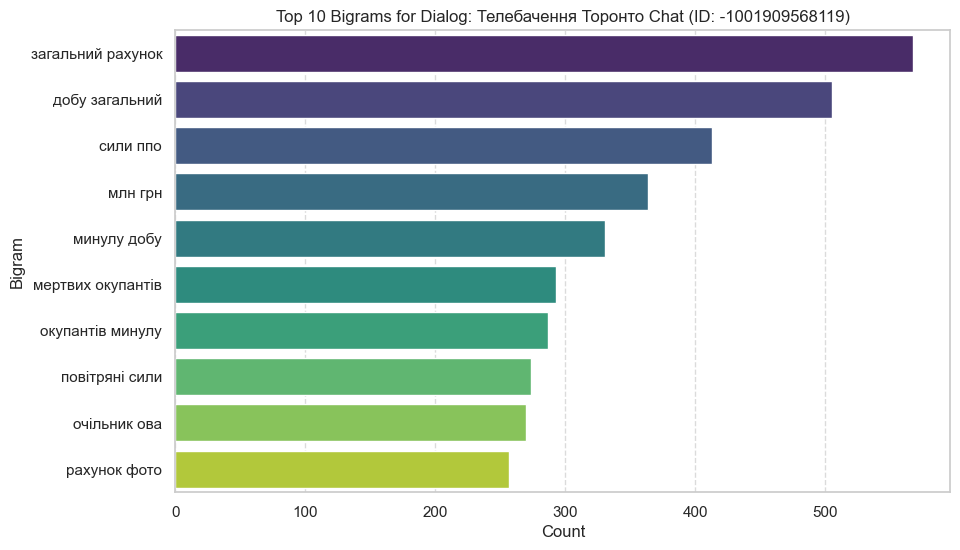

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2111161948.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigram_df, palette='viridis')


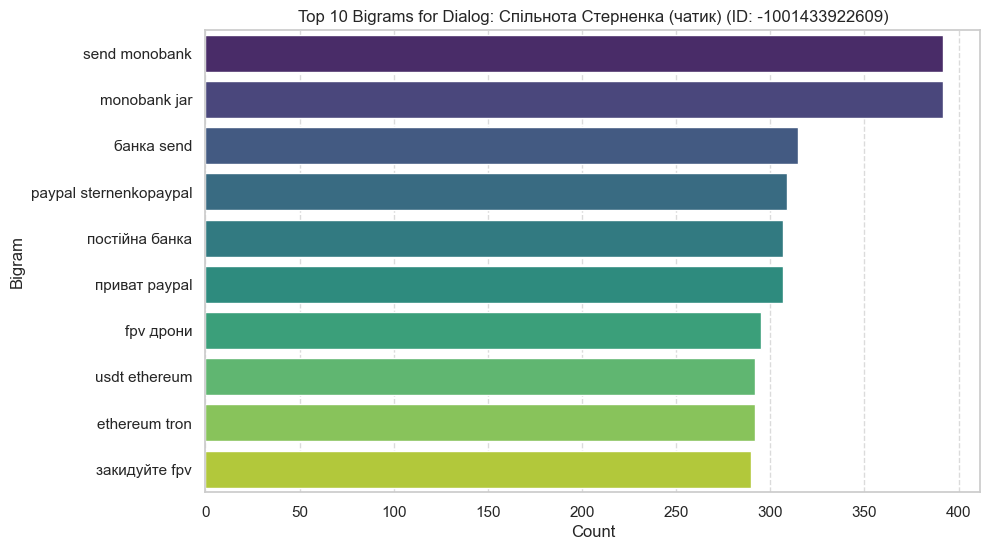

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2111161948.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigram_df, palette='viridis')


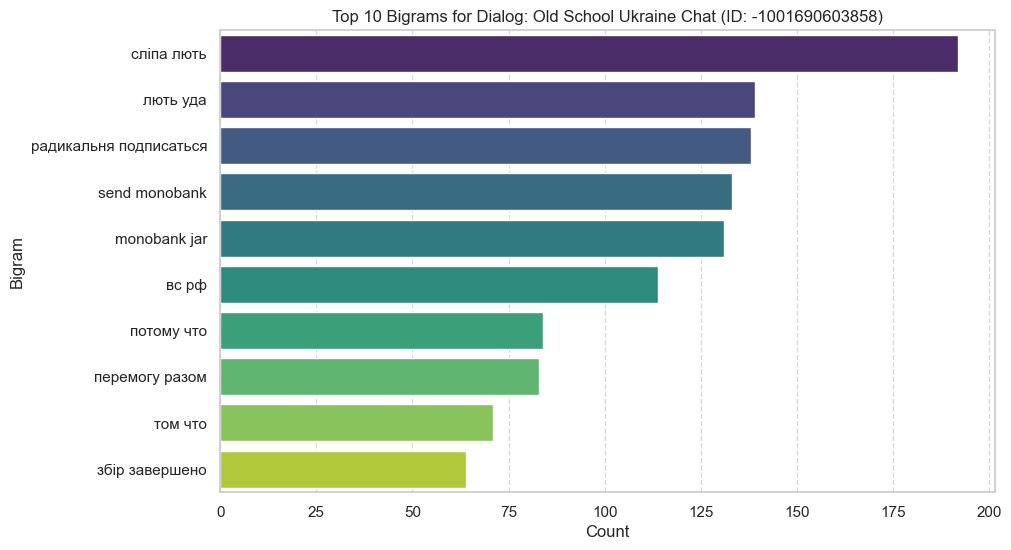

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2111161948.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigram_df, palette='viridis')


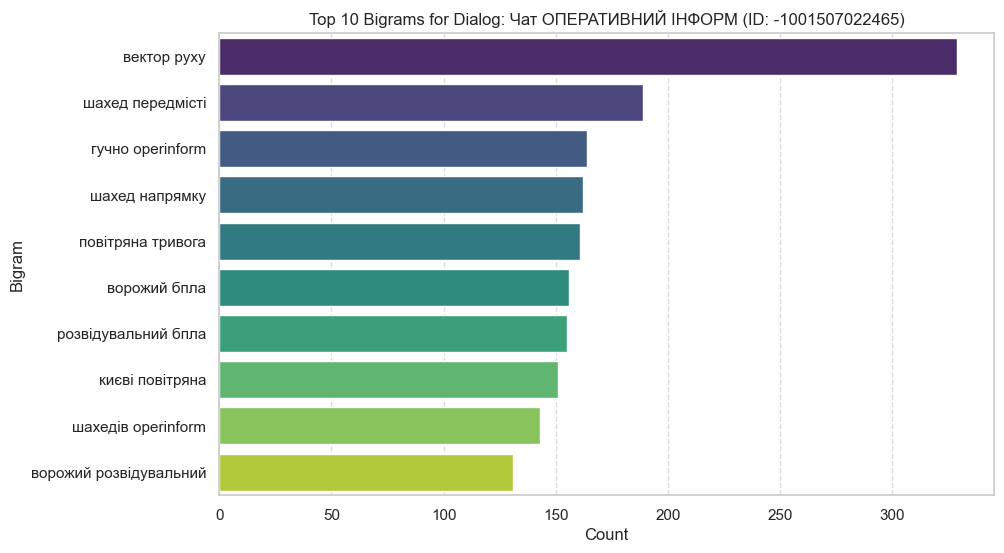

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2111161948.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigram_df, palette='viridis')
/Users/romanmalynovsky/.pyenv/versions/3.8.13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/romanmalynovsky/.pyenv/versions/3.8.13/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


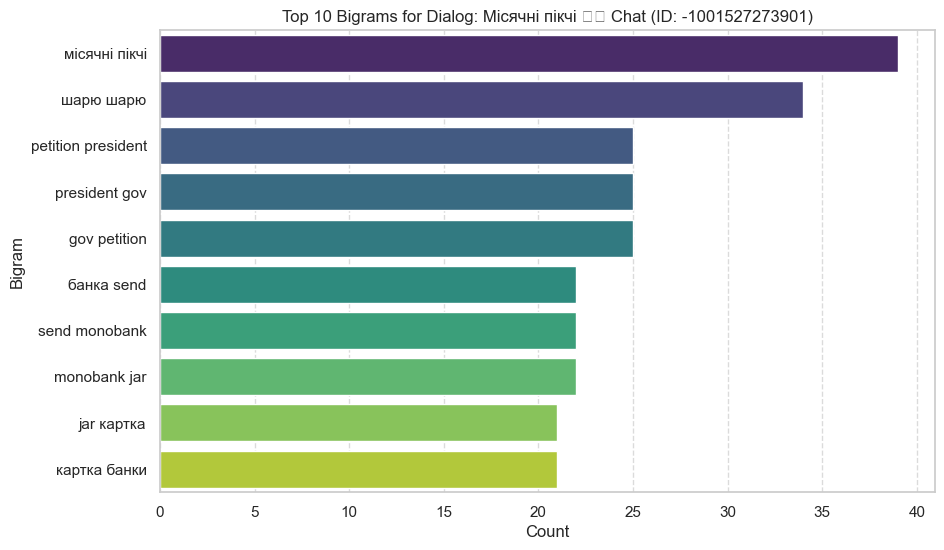

In [45]:
stop_words = set(stopwords.words('ukrainian'))
stop_words.update(stopwords.words('english'))

def get_bigrams(text):
    if isinstance(text, str):
        words = [word.lower() for word in re.findall(r'\b[a-zA-Zа-яА-ЯїЇєЄіІґҐ]+\b', text) if word.lower() not in stop_words]
        bigrams = list(ngrams(words, 2))  
        return bigrams
    return []

top_dialogs = df['dialog_id'].value_counts().head(5).index.tolist()
top_dialogs_df = df[df['dialog_id'].isin(top_dialogs)]

top_dialogs_df['bigrams'] = top_dialogs_df['message'].apply(get_bigrams)

for dialog_id in top_dialogs:
    dialog_data = top_dialogs_df[top_dialogs_df['dialog_id'] == dialog_id]
    bigrams = [bigram for bigrams_list in dialog_data['bigrams'] for bigram in bigrams_list]
    bigram_counts = Counter(bigrams)
    most_common_bigrams = bigram_counts.most_common(10)  # Top 10 bigrams

    dialog_name = df_meta[df_meta['dialog_id'] == dialog_id]['name'].iloc[0] if not df_meta[df_meta['dialog_id'] == dialog_id].empty else "Unknown"

    bigram_df = pd.DataFrame(most_common_bigrams, columns=['bigram', 'count'])
    bigram_df['bigram'] = bigram_df['bigram'].apply(lambda x: ' '.join(x))

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='bigram', data=bigram_df, palette='viridis')
    plt.title(f'Top 10 Bigrams for Dialog: {dialog_name} (ID: {dialog_id})')
    plt.xlabel('Count')
    plt.ylabel('Bigram')
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()


## Question 22
### How message type correlates with amount of got reactions?

/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1169628998.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reactions_dict'] = df['reactions'].apply(extract_reactions)
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1169628998.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reaction_count'] = df['reactions_dict'].apply(len)
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/1169628998.py:12: SettingWithCopyWarning: 
A value is trying to be set

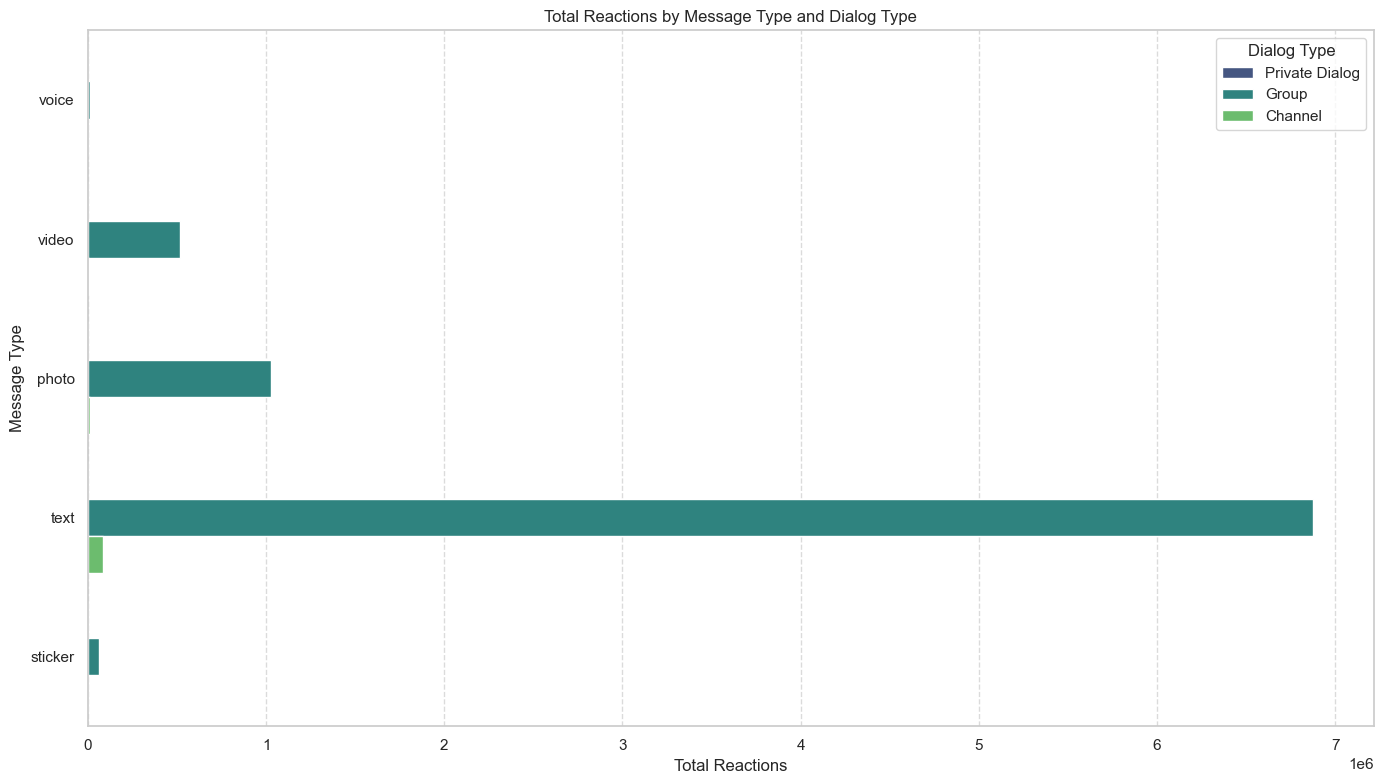

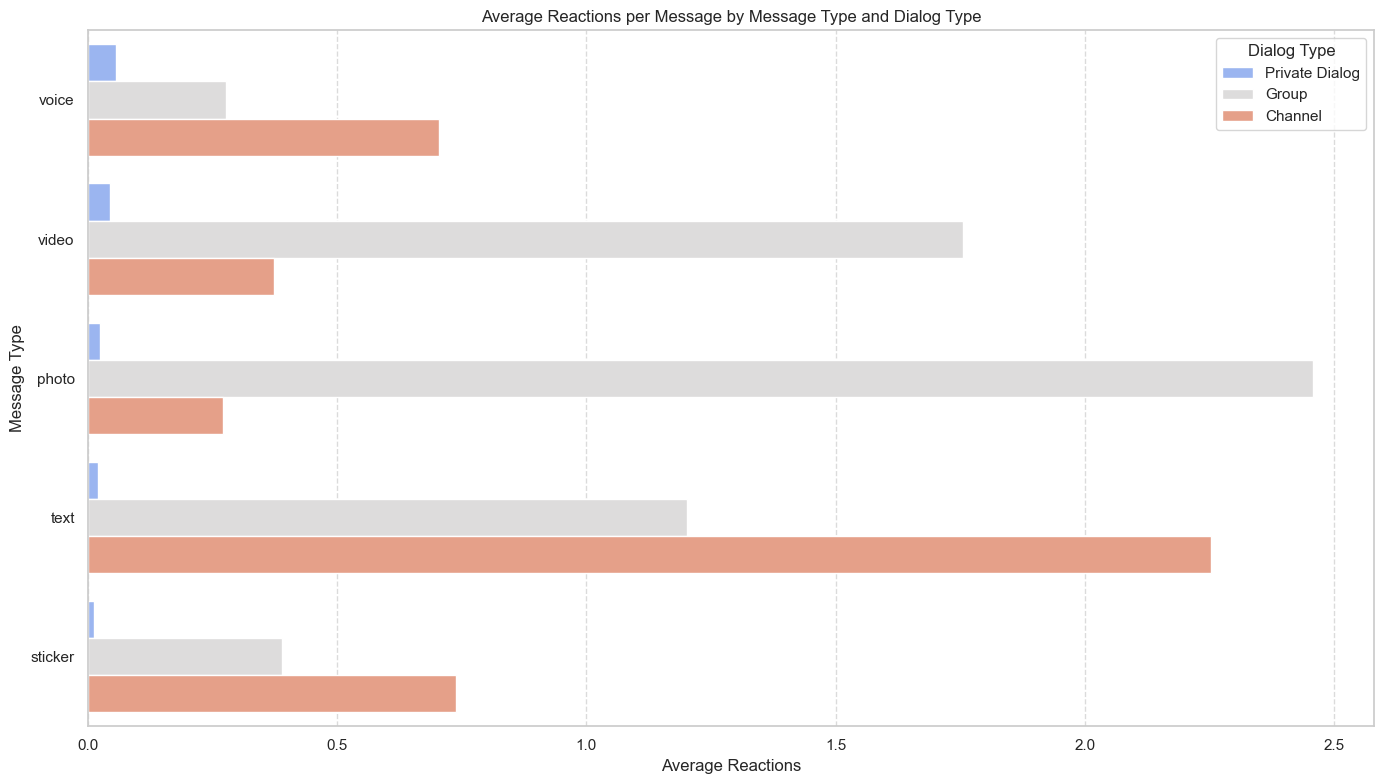

Top Message Types by Average Reactions:
         total_reactions  total_messages  avg_reactions dialog_type
type                                                               
photo            1029887          419188       2.456862       Group
text               83812           37206       2.252647     Channel
video             518931          295689       1.754989       Group
text             6873914         5721663       1.201384       Group
sticker              433             586       0.738908     Channel
voice                 98             139       0.705036     Channel
sticker            64427          165112       0.390202       Group
video               5685           15260       0.372543     Channel
voice              10573           38201       0.276773       Group
photo               9247           34220       0.270222     Channel


In [46]:
def extract_reactions(reactions):
    try:
        if isinstance(reactions, str):
            reactions_dict = ast.literal_eval(reactions)
            if isinstance(reactions_dict, dict):
                return reactions_dict
        return {}
    except (ValueError, SyntaxError):
        return {}

def analyze_reactions_by_type(df, dialog_type):
    df['reactions_dict'] = df['reactions'].apply(extract_reactions)
    df['reaction_count'] = df['reactions_dict'].apply(len)

    reaction_analysis = df.groupby('type').agg(
        total_reactions=('reaction_count', 'sum'),
        total_messages=('type', 'count'),
        avg_reactions=('reaction_count', 'mean')
    ).sort_values(by='avg_reactions', ascending=False)

    reaction_analysis['dialog_type'] = dialog_type
    return reaction_analysis

private_reactions = analyze_reactions_by_type(private_df, 'Private Dialog')
group_reactions = analyze_reactions_by_type(groups_df, 'Group')
channel_reactions = analyze_reactions_by_type(channels_df, 'Channel')

reaction_summary = pd.concat([private_reactions, group_reactions, channel_reactions])

plt.figure(figsize=(14, 8))
sns.barplot(
    data=reaction_summary,
    x='total_reactions',
    y=reaction_summary.index,
    hue='dialog_type',
    palette='viridis'
)
plt.title('Total Reactions by Message Type and Dialog Type')
plt.xlabel('Total Reactions')
plt.ylabel('Message Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title='Dialog Type')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(
    data=reaction_summary,
    x='avg_reactions',
    y=reaction_summary.index,
    hue='dialog_type',
    palette='coolwarm'
)
plt.title('Average Reactions per Message by Message Type and Dialog Type')
plt.xlabel('Average Reactions')
plt.ylabel('Message Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title='Dialog Type')
plt.tight_layout()
plt.show()

print("Top Message Types by Average Reactions:")
print(reaction_summary.sort_values(by='avg_reactions', ascending=False).head(10))


## Question 23
### What messages what forwarded the most amount of times in all chats?

In [ ]:
def analyze_forwarded_messages(df):
    df['is_forwarded'] = df['fwd_from'].notna()

    total_messages = len(df)
    total_forwarded = df['is_forwarded'].sum()
    forwarding_ratio = total_forwarded / total_messages * 100

    print(f"Total messages: {total_messages}")
    print(f"Total forwarded messages: {total_forwarded}")
    print(f"Forwarding ratio: {forwarding_ratio:.2f}%")

    forwarded_messages = df[df['is_forwarded']]

    forwarded_counts = forwarded_messages['fwd_from'].value_counts()

    top_forwarded_messages = forwarded_messages.groupby('message').size().sort_values(ascending=False).head(10)

    return forwarded_messages, forwarded_counts, top_forwarded_messages


forwarded_messages, forwarded_counts, top_forwarded_messages = analyze_forwarded_messages(df)


Total messages: 87411
Total forwarded messages: 63462
Forwarding ratio: 72.60%


/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/96637711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_forwarded'] = df['fwd_from'].notna()


/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/781058799.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=forwarded_counts_clean.index, y=forwarded_counts_clean.values, palette='viridis')


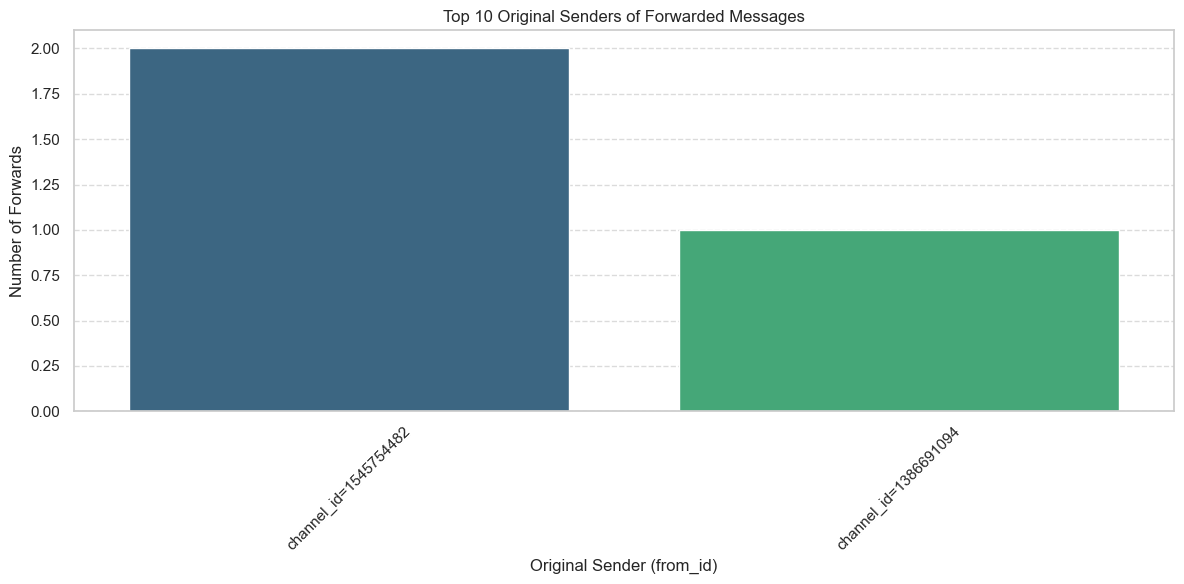

In [48]:
forwarded_counts_clean = forwarded_counts.head(10)
forwarded_counts_clean.index = forwarded_counts_clean.index.map(lambda x: str(x).split('(')[-1].split(')')[0])

plt.figure(figsize=(12, 6))
sns.barplot(x=forwarded_counts_clean.index, y=forwarded_counts_clean.values, palette='viridis')
plt.title('Top 10 Original Senders of Forwarded Messages')
plt.xlabel('Original Sender (from_id)')
plt.ylabel('Number of Forwards')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2637565635.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_forwarded_messages_truncated.values, y=top_forwarded_messages_truncated.index, palette='viridis')
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2637565635.py:17: UserWarning: Glyph 128558 (\N{FACE WITH OPEN MOUTH}) missing from current font.
  plt.tight_layout()
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2637565635.py:17: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from current font.
  plt.tight_layout()
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/2637565635.py:17: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
/var/folders/pc/vqmykl894s313p24rdg7r01w0000gn/T/ipykernel_87721/26375656

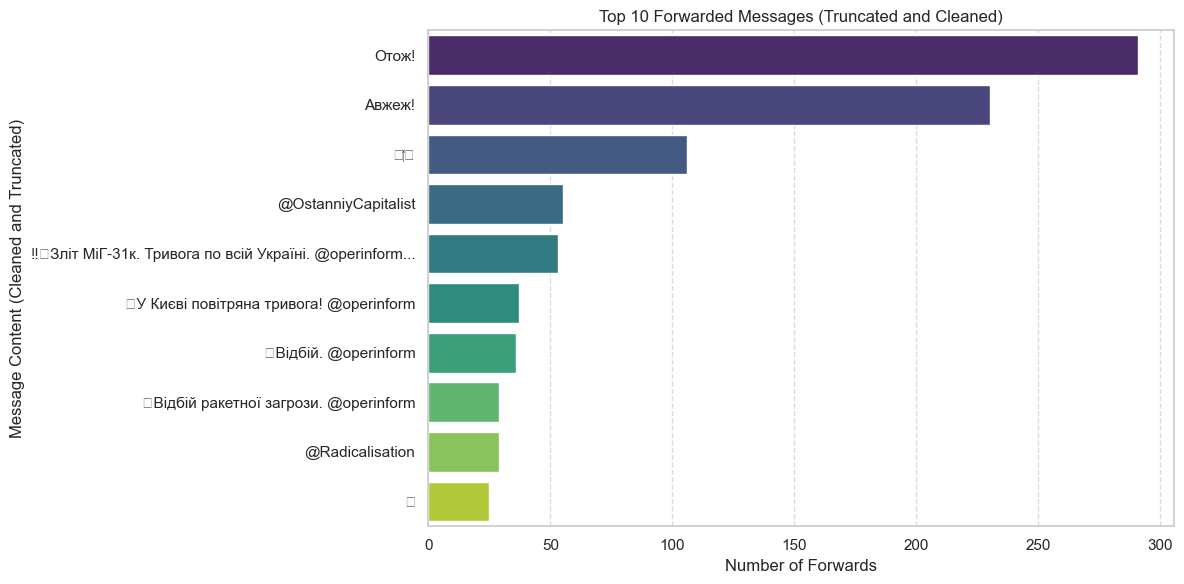

In [55]:
top_forwarded_messages_cleaned = top_forwarded_messages.copy()
top_forwarded_messages_cleaned.index = top_forwarded_messages_cleaned.index.str.replace(r'\s+', ' ', regex=True).str.strip()

def truncate_message(msg):
    return msg[:70] + '...' if len(msg) > 50 else msg

top_forwarded_messages_truncated = top_forwarded_messages_cleaned.copy()
top_forwarded_messages_truncated.index = top_forwarded_messages_truncated.index.map(truncate_message)


plt.figure(figsize=(12, 6))
sns.barplot(x=top_forwarded_messages_truncated.values, y=top_forwarded_messages_truncated.index, palette='viridis')
plt.title('Top 10 Forwarded Messages (Truncated and Cleaned)')
plt.xlabel('Number of Forwards')
plt.ylabel('Message Content (Cleaned and Truncated)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [56]:
print("Top 10 Forwarded Messages (Cleaned and Truncated):")
for message, count in zip(top_forwarded_messages_cleaned.index, top_forwarded_messages_cleaned.values):
    print(f"Message: {message[:50]}... | Forwarded Count: {count}")

Top 10 Forwarded Messages (Cleaned and Truncated):
Message: Отож!... | Forwarded Count: 291
Message: Авжеж!... | Forwarded Count: 230
Message: 😮‍💨... | Forwarded Count: 106
Message: @OstanniyCapitalist... | Forwarded Count: 55
Message: ‼️Зліт МіГ-31к. Тривога по всій Україні. @operinfo... | Forwarded Count: 53
Message: 🔴У Києві повітряна тривога! @operinform... | Forwarded Count: 37
Message: 🟢Відбій. @operinform... | Forwarded Count: 36
Message: 🟢Відбій ракетної загрози. @operinform... | Forwarded Count: 29
Message: @Radicalisation... | Forwarded Count: 29
Message: 🫤... | Forwarded Count: 25


# Conclusion

### This analysis provided valuable insights into my activity on Telegram. Through this homework, I was able to identify key behavioral patterns, including peak activity times, message reactions, media usage, and the spread of messages across chats.